<a href="https://colab.research.google.com/github/BianchiLuca28/FHNW-BI-LMS/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Overview
- Predictive model to determine "service_type" for shipments by a B2B company using third-party carriers.
- Dataset includes details like customer pricing, carrier pricing, shipment weights, and delivery locations.
- Objective: Predict service type using machine learning.

## Business Motivation
- **Operational Efficiency**: Optimize logistics and resource allocation.
- **Cost Savings**: Identify cost reduction opportunities.
- **Customer Experience**: Offer tailored services.
- **Strategic Insights**: Analyze profitability across service types.

## Data Analysis and Preprocessing
- **EDA**: Understand features, identify outliers, and class imbalance.
- **Preprocessing**: Feature selection, outlier removal, encoding, and margin estimation.

## Modeling Process
- **Imbalanced Data Challenge**: "Special" class had only 7 instances.
- Attempts to balance data included SMOTE and class weight adjustments.
- **Outcome**: "Special" class excluded due to insufficient data.

## Model Selection and Evaluation
- **Algorithms**: Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, LightGBM.
- **Metrics**: Accuracy, ROC AUC, classification reports.
- **Final Model**: Random Forest selected for balanced performance with a Test Set Accuracy: 0.9753.

## Conclusion
- Model effectively predicts service types, excluding "Special".
- Supports operational decisions and improves business outcomes.

# Imports

In [43]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Oversampling
from imblearn.over_sampling import SMOTE

# Statistical tools
from scipy import stats

# Importing dataset

Importing the dataset from the online source in Google Drive

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Change with your location to read the dataset from
folder_path = "/content/drive/MyDrive/__Shared/BI"

In [46]:
df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")

# Exploratory Data Analysis (EDA)

Exploring the dataset with various analysis, without performing any kind of preprocessing.

In here we analyze:
- Basic data visualization.
- Check duplicates.
- Missing values.
- Correlations.
- Distributions.
- Outliers.
- The target variable "service_type".
- Feature importance.




## Basic Data Exploration

In [47]:
# Basic Data Overview
print("Dataset Overview:")
display(df.head())

# Summary statistics for numerical features
print("\nSummary Statistics:")
display(df.describe())

# Data types and missing value counts
print("\nData Types and Missing Values:")
print(df.dtypes)
print("\nMissing Values Count:")
print(df.isnull().sum())

Dataset Overview:


shipment_id  customer_price  expected_carrier_price  final_carrier_price  \
0      4499940            8.64                    5.92                 4.96   
1      4505367           19.24                   10.93                 8.47   
2      4536217           19.16                   10.89                 8.46   
3      4554860           99.04                   62.09                59.15   
4      4557691            6.70                    5.88                 4.63   

   weight shipment_type insurance_type  customer_id domain_name  \
0     1.5        Parcel   No_Insurance        20378          DE   
1    18.0        Parcel   No_Insurance        80847          DE   
2    18.0        Parcel   No_Insurance        80847          DE   
3     3.2        Parcel   No_Insurance       157579          DE   
4     2.0        Parcel   No_Insurance        66718          DE   

   booking_state  ...  quarter_pickup_date  year_delivery_date  \
0             12  ...                    1              2022.0   
1             12  ...                    1              2022.0   
2             12  ...                    1              2022.0   
3             12  ...                    1              2022.0   
4             12  ...                    1              2023.0   

   month_delivery_date quarter_delivery_date year_real_pickup_date  \
0                 11.0                   4.0                  2023   
1                 12.0                   4.0                  2023   
2                 12.0                   4.0                  2023   
3                 12.0                   4.0                  2023   
4                  1.0                   1.0                  2022   

  month_real_pickup_date  quarter_real_pickup_date  year_real_delivery_date  \
0                      1                         1                     2023   
1                      1                         1                     2023   
2                      1                         1                     2023   
3                      1                         1                     2023   
4                     12                         4                     2022   

   month_real_delivery_date  quarter_real_delivery_date  
0                         1                           1  
1                         1                           1  
2                         1                           1  
3                         1                           1  
4                        12                           4  

[5 rows x 52 columns]


Summary Statistics:


shipment_id  customer_price  expected_carrier_price  \
count  6.568020e+05   656802.000000           656802.000000   
mean   4.950690e+06       46.457547               30.194389   
std    2.196784e+05      109.466604               73.354634   
min    4.473042e+06      -24.210000             -119.930000   
25%    4.760386e+06        9.530000                6.630000   
50%    4.950494e+06       20.020000               13.010000   
75%    5.140942e+06       45.170000               28.110000   
max    5.435342e+06    10966.180000             7963.940000   

       final_carrier_price         weight    customer_id  booking_state  \
count        552628.000000  656802.000000  656802.000000  656802.000000   
mean             29.622556      11.075398   77202.130639      12.000257   
std              69.727994      33.553862   50912.392470       0.045117   
min            -118.260000       0.010000       1.000000       7.000000   
25%               8.360000       1.180000   33531.000000      12.000000   
50%              13.660000       3.500000   68430.000000      12.000000   
75%              28.130000      10.590000  123446.000000      12.000000   
max            7961.540000    3315.000000  177551.000000      19.000000   

            lms_plus     exworks_id         margin  ...  quarter_pickup_date  \
count  656802.000000   25860.000000  552628.000000  ...        656802.000000   
mean        0.141822  177451.010673      20.937577  ...             2.494610   
std         0.348868   14304.951214      51.335484  ...             1.122957   
min         0.000000  153422.000000   -1059.350000  ...             1.000000   
25%         0.000000  164783.750000       3.400000  ...             1.000000   
50%         0.000000  176850.500000       7.810000  ...             2.000000   
75%         0.000000  189782.250000      20.140000  ...             4.000000   
max         1.000000  203057.000000    3511.600000  ...             4.000000   

       year_delivery_date  month_delivery_date  quarter_delivery_date  \
count       520328.000000        520328.000000          520328.000000   
mean          2023.001845             6.571953               2.514047   
std              0.044106             3.432719               1.122848   
min           2022.000000             1.000000               1.000000   
25%           2023.000000             4.000000               2.000000   
50%           2023.000000             7.000000               3.000000   
75%           2023.000000            10.000000               4.000000   
max           2024.000000            12.000000               4.000000   

       year_real_pickup_date  month_real_pickup_date  \
count           656802.00000           656802.000000   
mean              2023.00143                6.493357   
std                  0.09327                3.431337   
min               1970.00000                1.000000   
25%               2023.00000                3.000000   
50%               2023.00000                6.000000   
75%               2023.00000               10.000000   
max               2025.00000               12.000000   

       quarter_real_pickup_date  year_real_delivery_date  \
count             656802.000000            656802.000000   
mean                   2.491736              2023.007089   
std                    1.122381                 0.207792   
min                    1.000000              2022.000000   
25%                    1.000000              2023.000000   
50%                    2.000000              2023.000000   
75%                    4.000000              2023.000000   
max                    4.000000              2138.000000   

       month_real_delivery_date  quarter_real_delivery_date  
count             656802.000000               656802.000000  
mean                   6.531300                    2.502074  
std                    3.431827                    1.122614  
min                    1.000000                    1.000000  
25%                    3.0000


Data Types and Missing Values:
shipment_id                        int64
customer_price                   float64
expected_carrier_price           float64
final_carrier_price              float64
weight                           float64
shipment_type                     object
insurance_type                    object
customer_id                        int64
domain_name                       object
booking_state                      int64
lms_plus                           int64
exworks_id                       float64
margin                           float64
domain_name_customer              object
main_industry_name_customer       object
industry_sector_name_customer     object
segmentation_customer            float64
sequence_number_customer           int64
structure_number_customer          int64
is_master_customer                  bool
domain_name_delivery              object
postal_code_delivery              object
city_delivery                     object
name_country_delivery    

## Duplicates Analysis

From the analysis we can see that there are no duplicates.

In [48]:
# Check for duplicate rows in the dataset
duplicates = df[df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicates.shape[0]}")

# Optionally, display the duplicate rows
if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows: 0


## Missing Values Analysis

Some columns have too many null values to be treated.

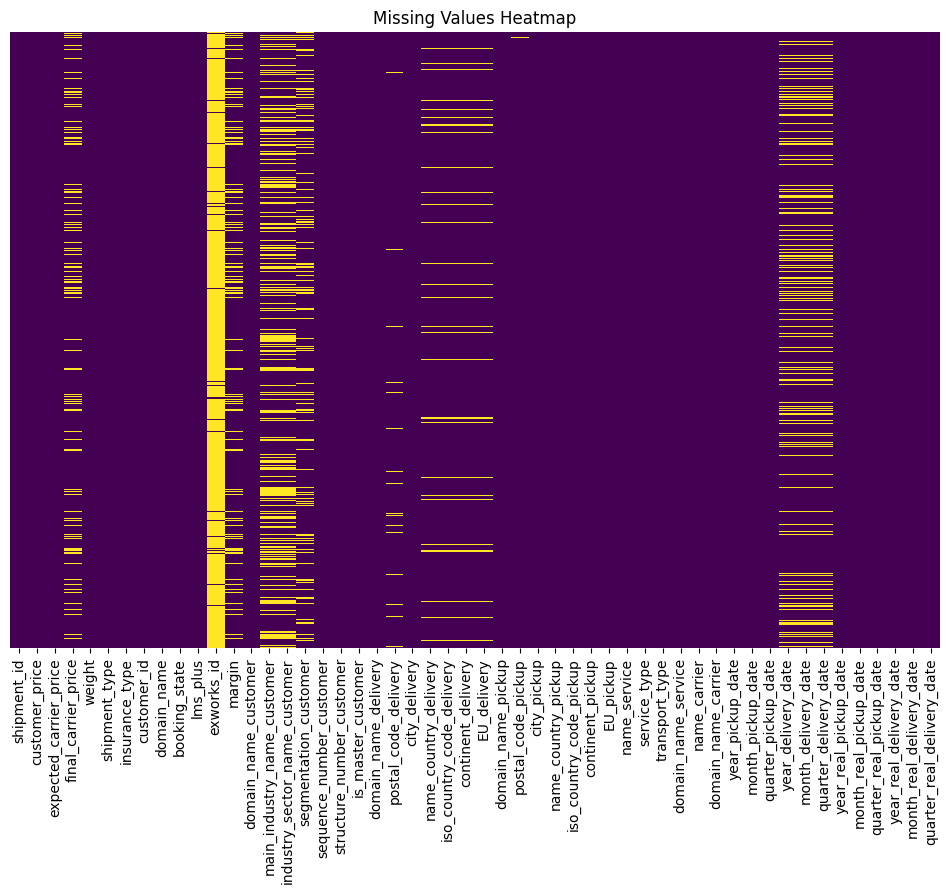

In [49]:
# Heatmap to visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

## Correlation Heatmap for Numerical Features

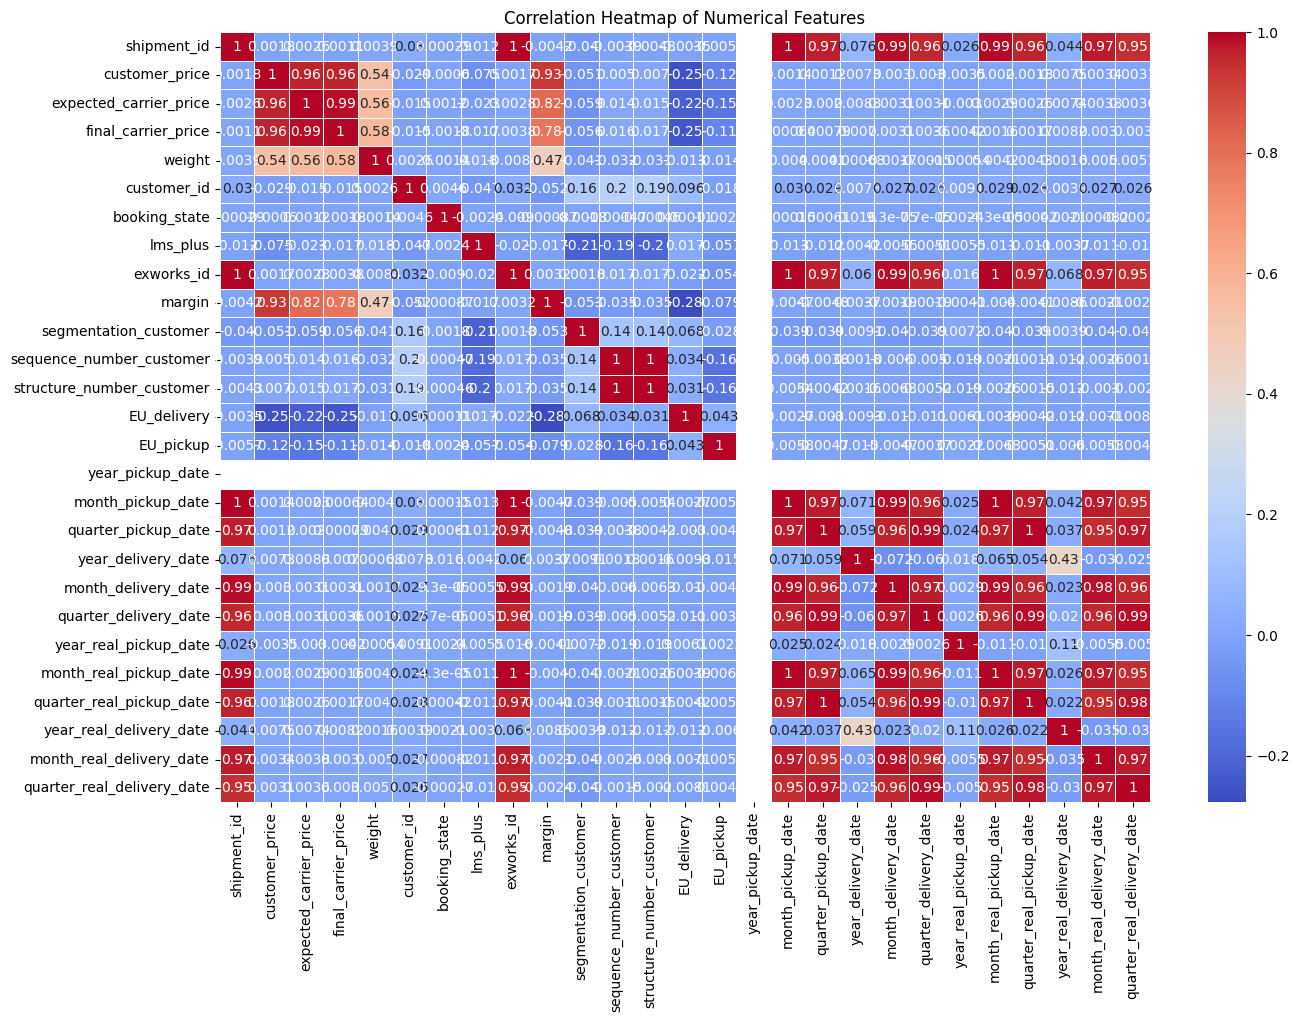

In [50]:
# Select only numerical columns
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap for numerical features
plt.figure(figsize=(15, 10))
corr_matrix = numerical_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## Visualizing Feature Distributions

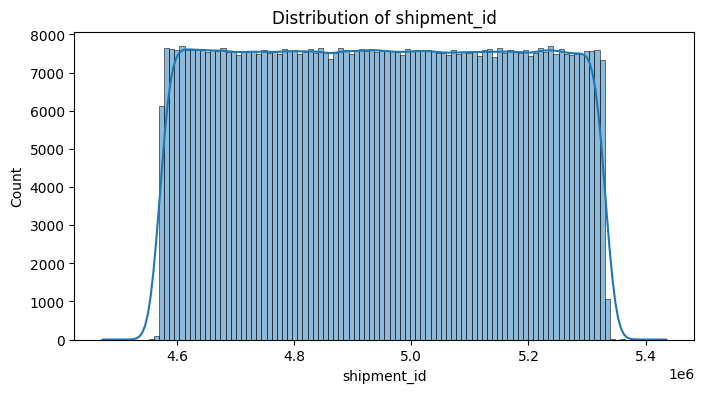

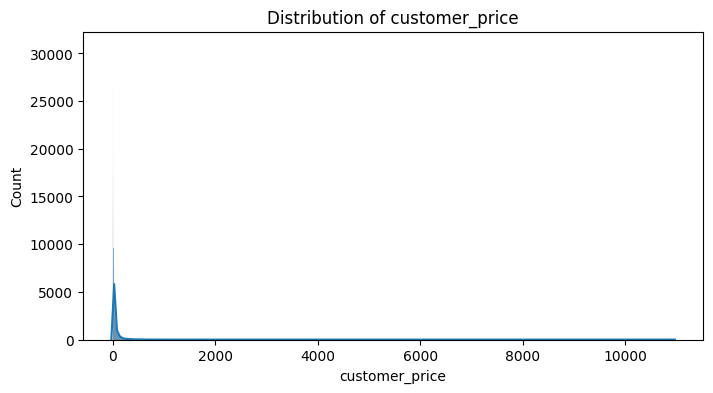

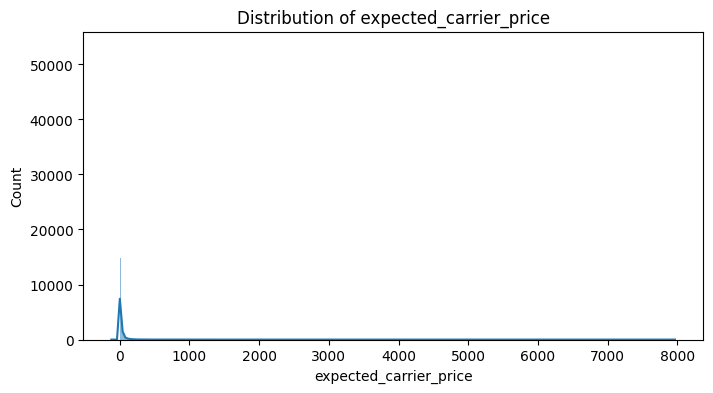

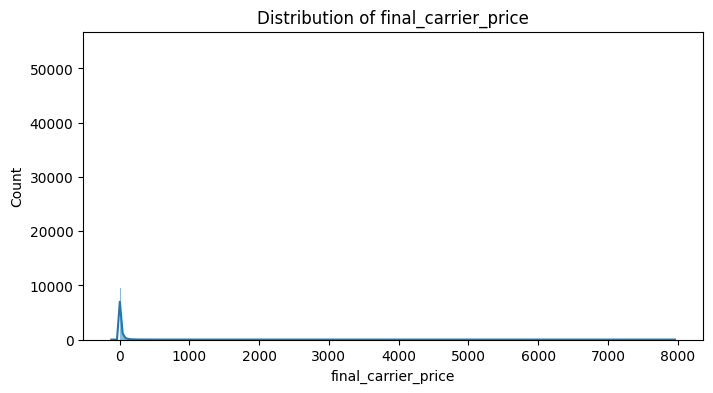

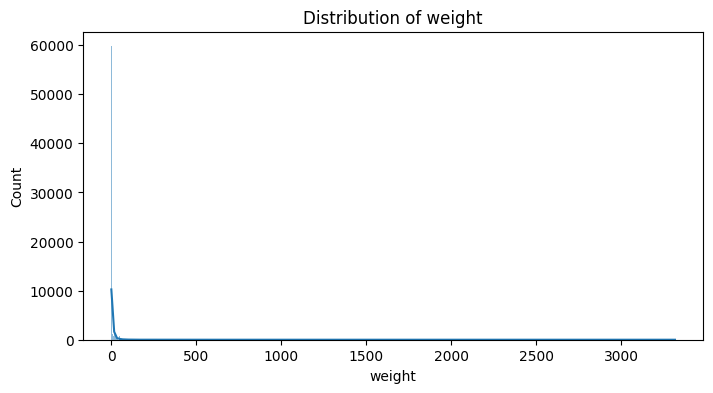

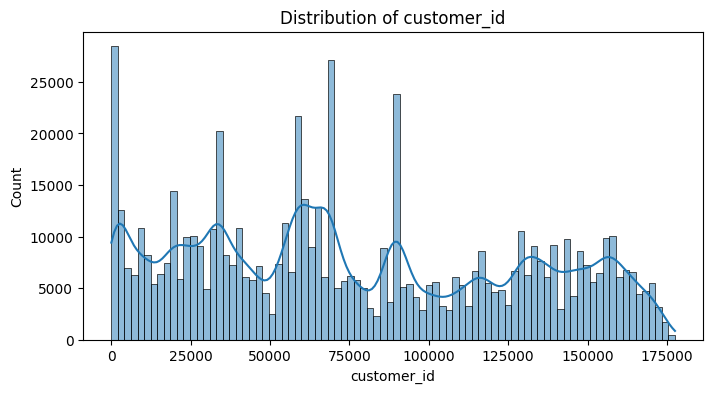

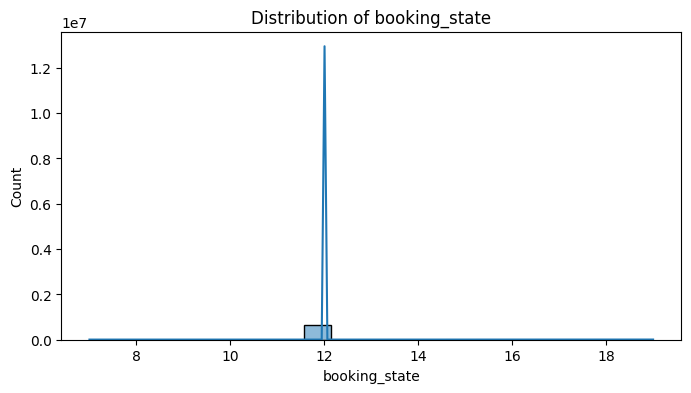

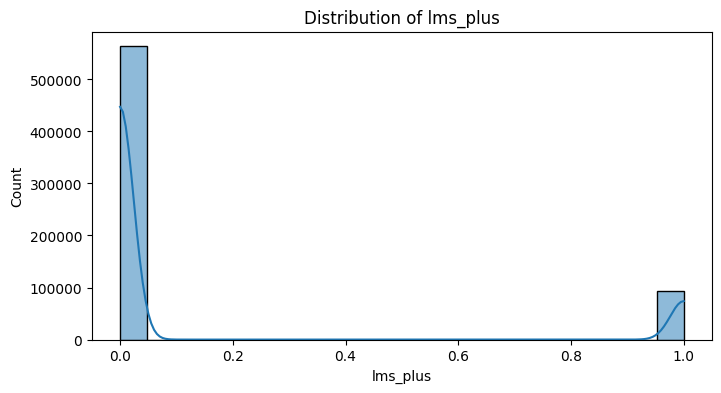

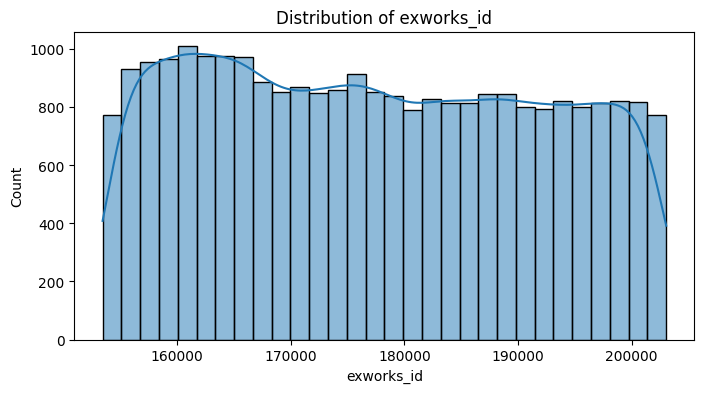

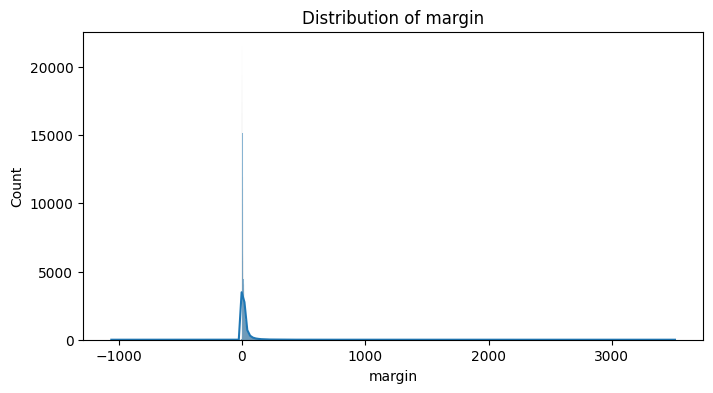

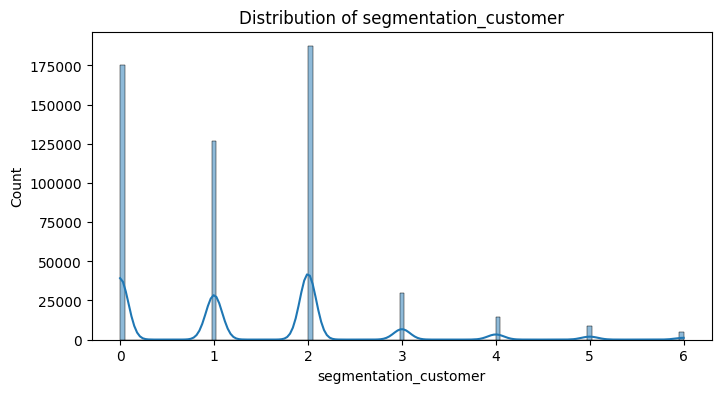

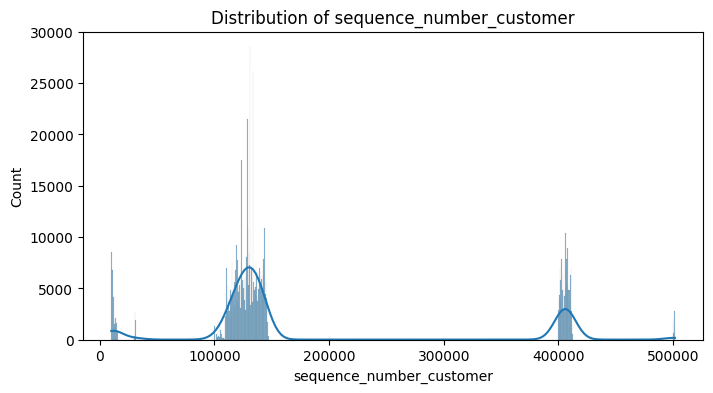

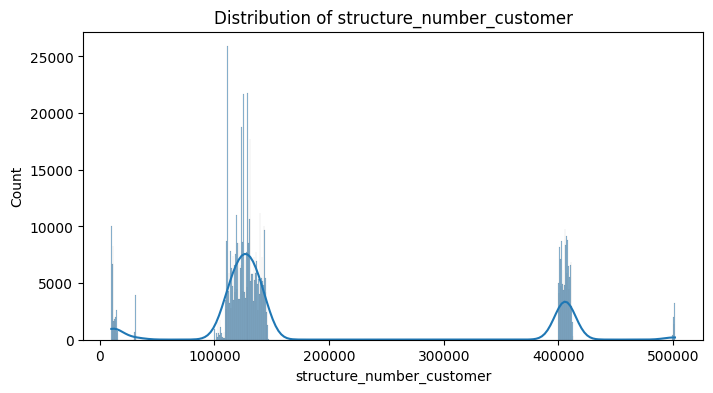

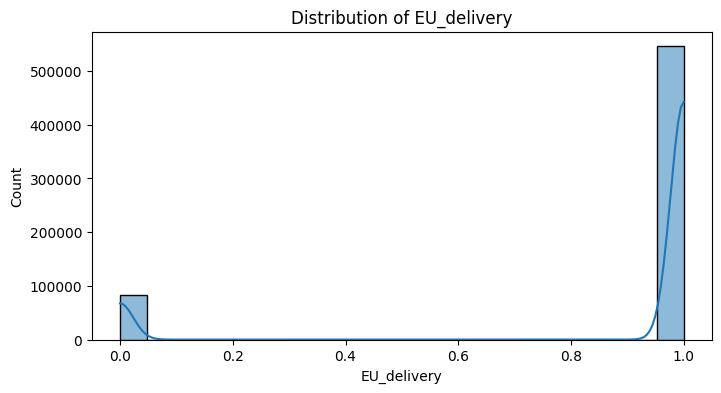

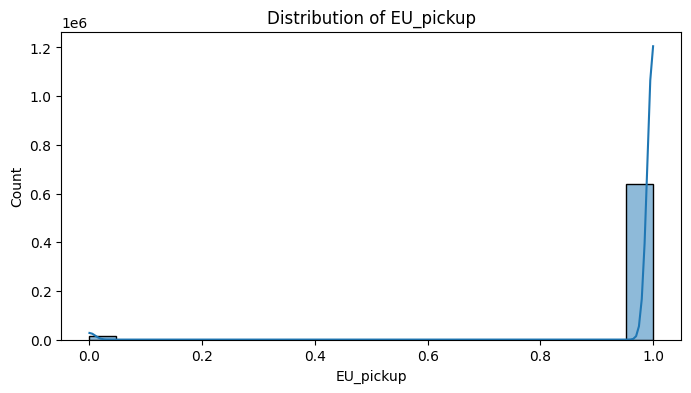

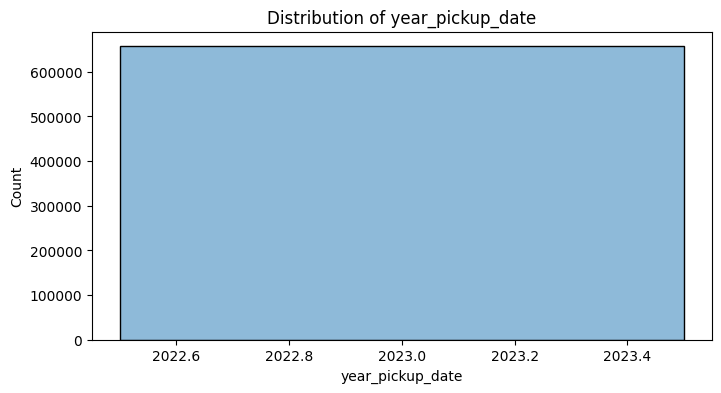

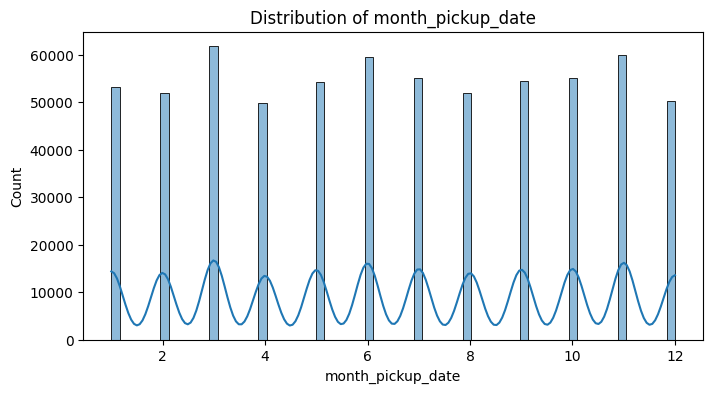

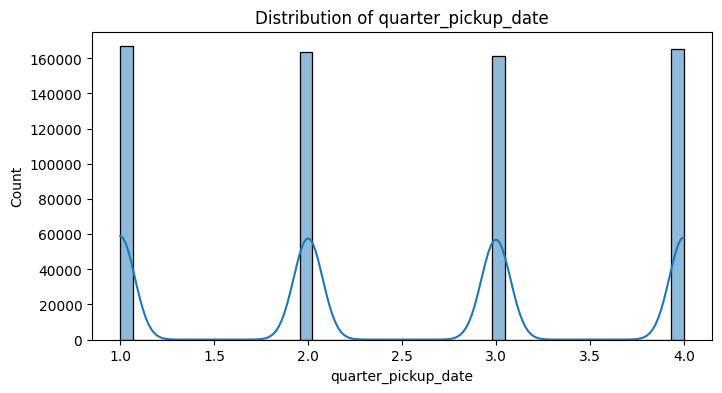

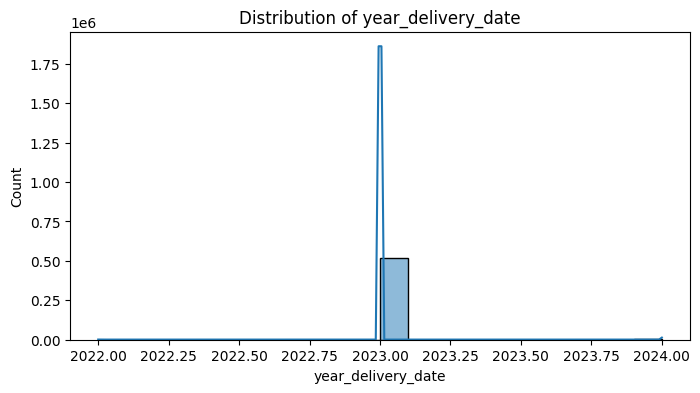

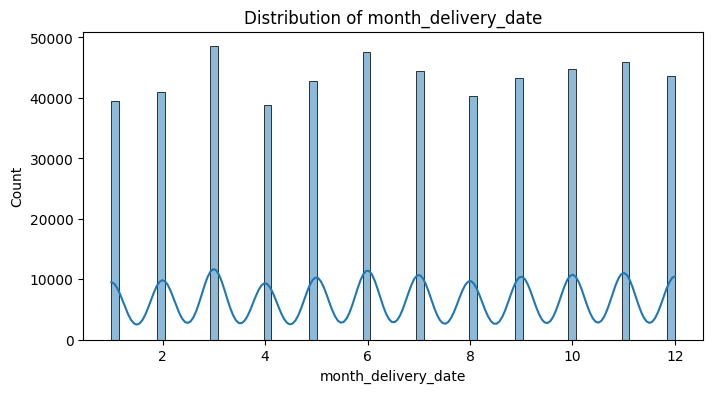

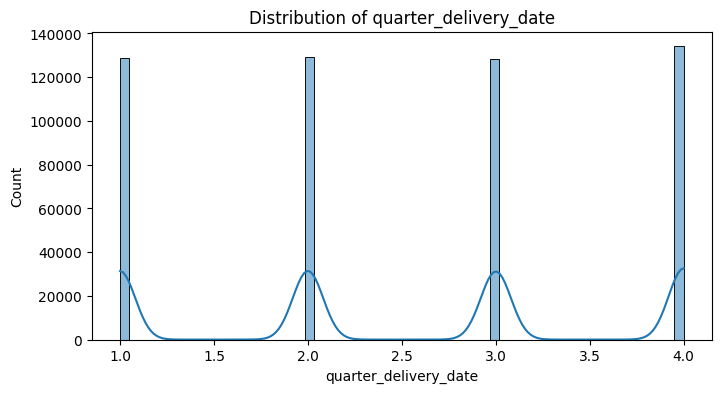

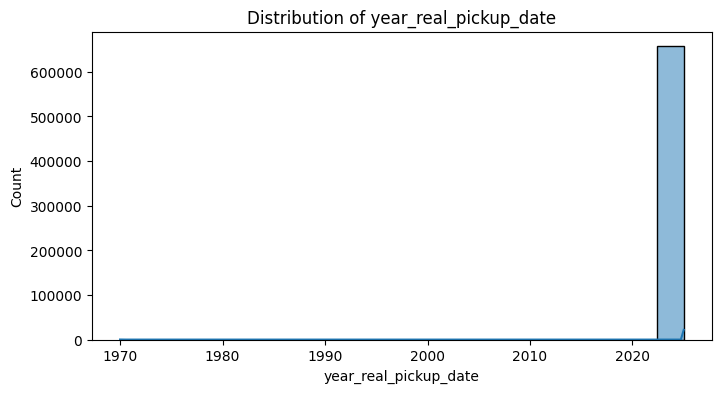

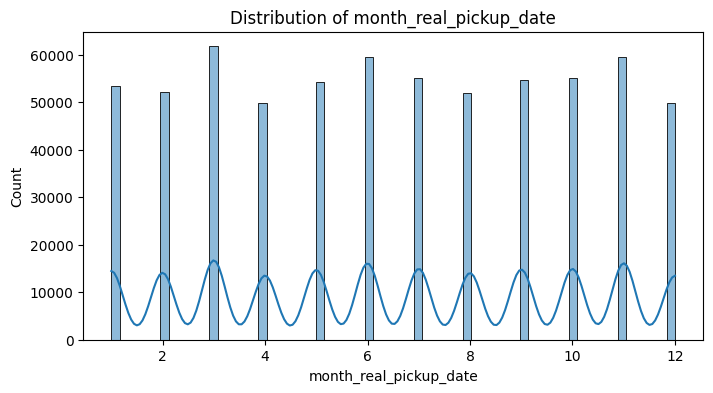

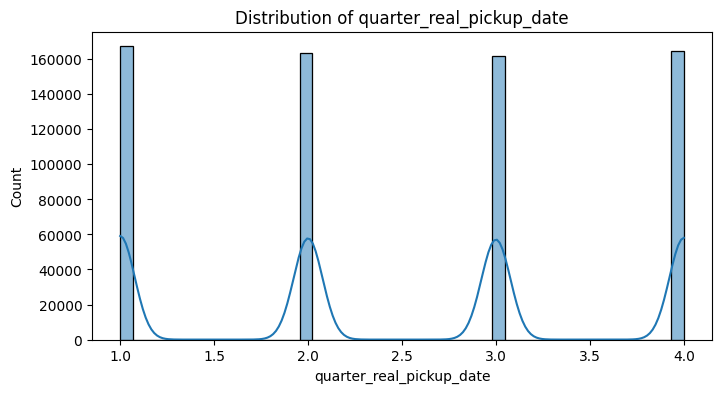

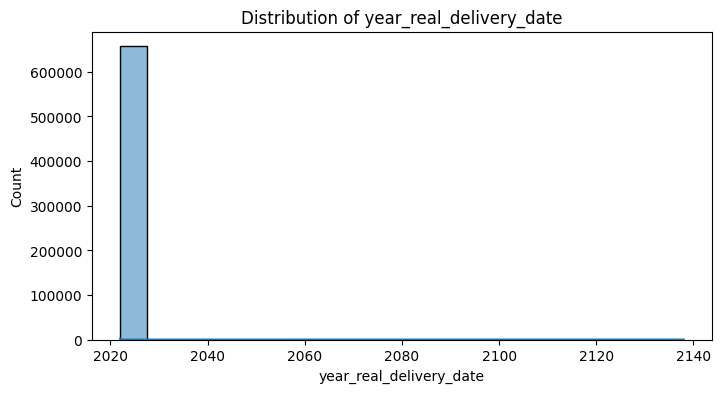

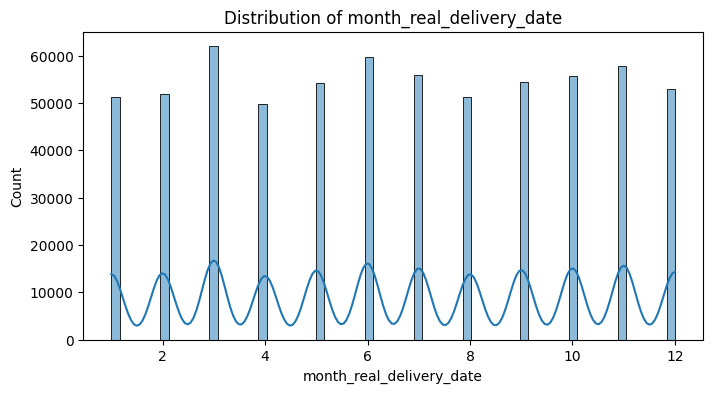

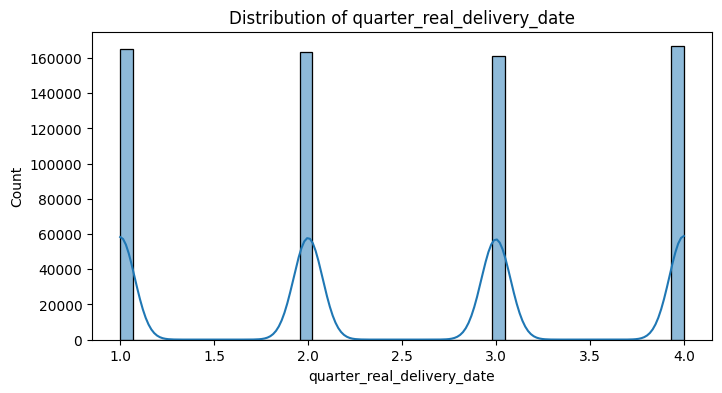

In [51]:
# Plot distribution for each numerical feature
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.show()

## Box Plots for Outlier Detection

There are some columns with many outliers.

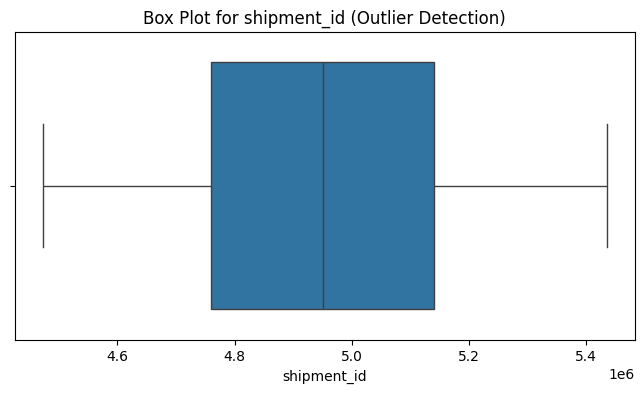

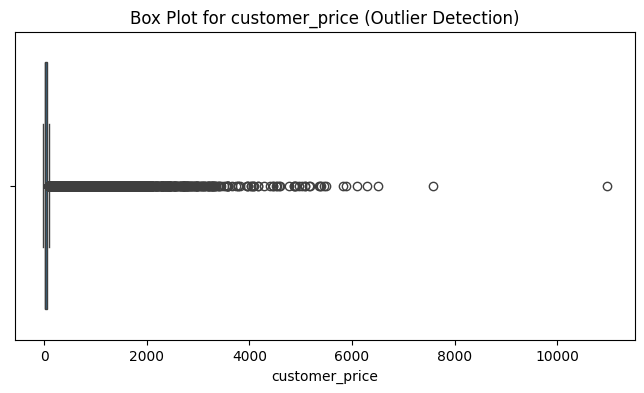

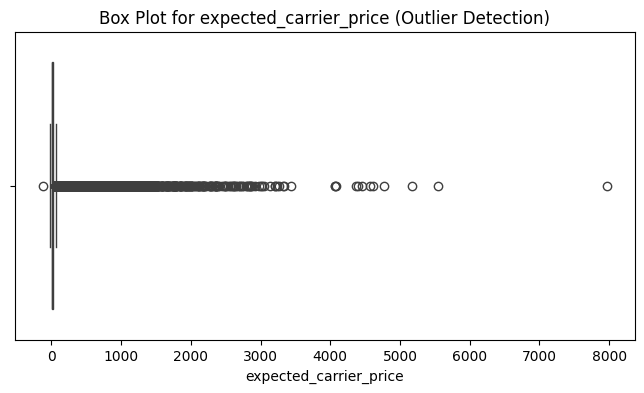

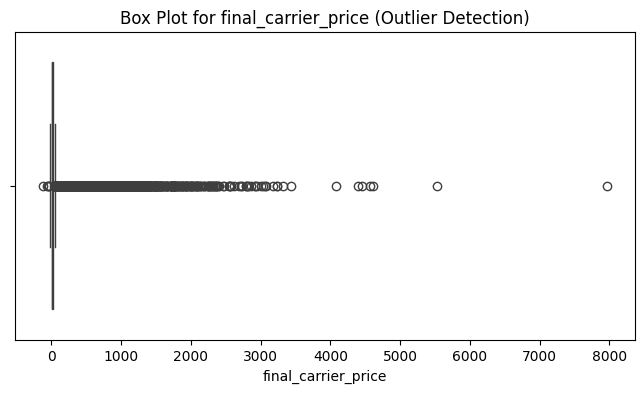

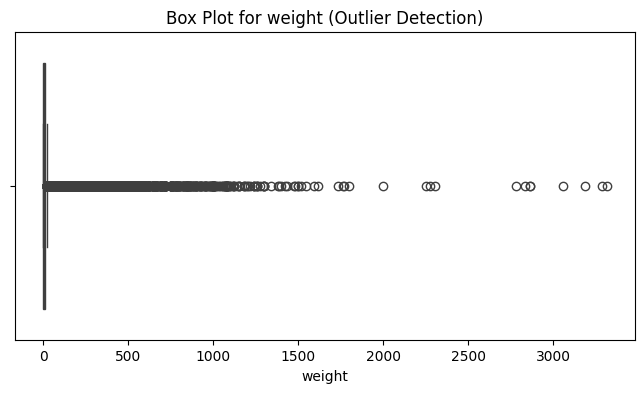

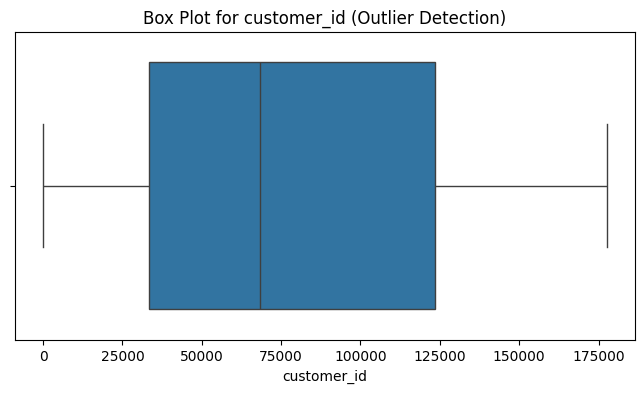

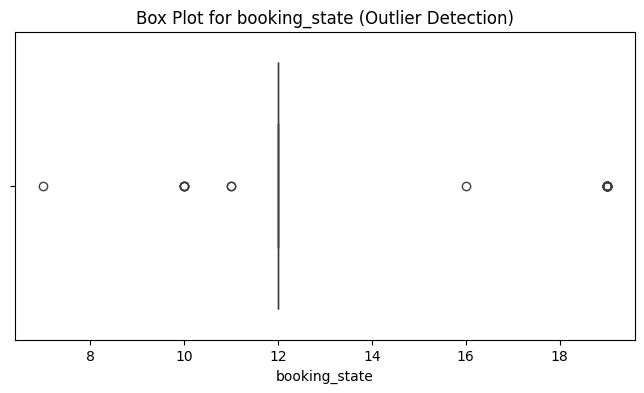

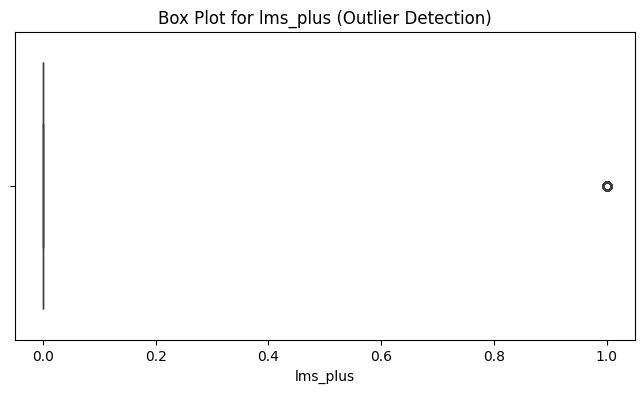

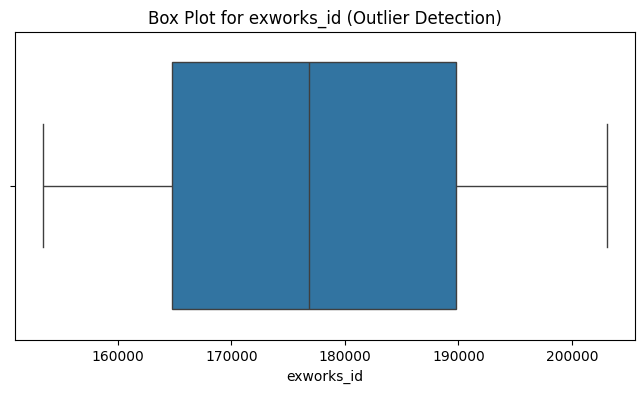

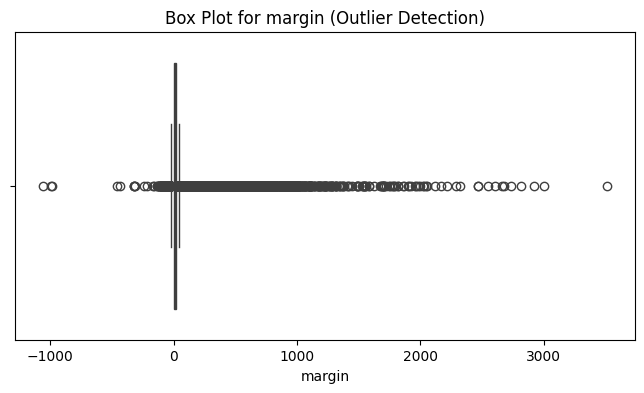

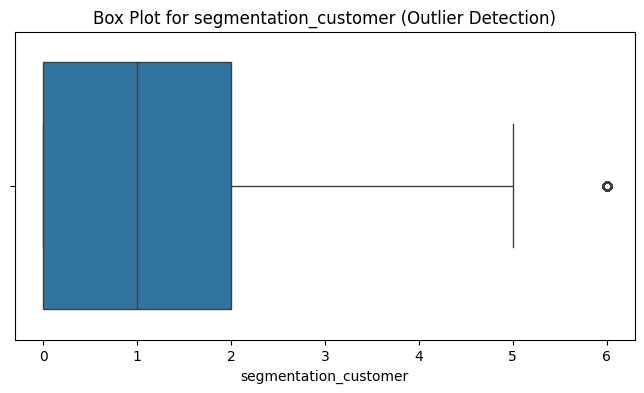

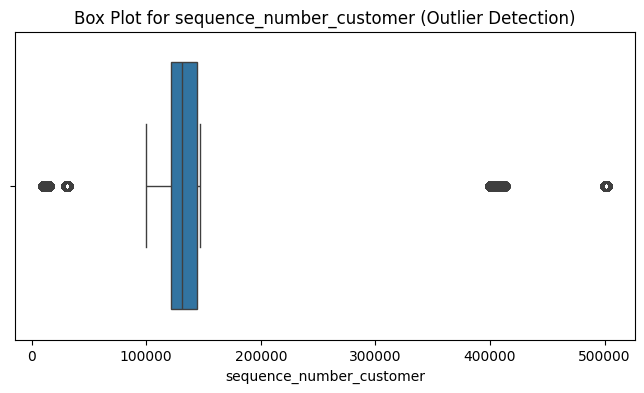

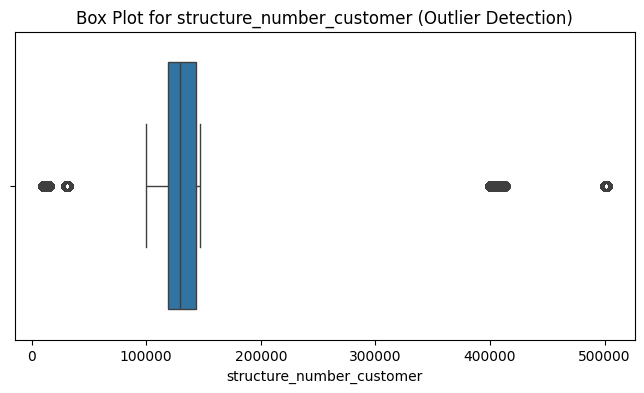

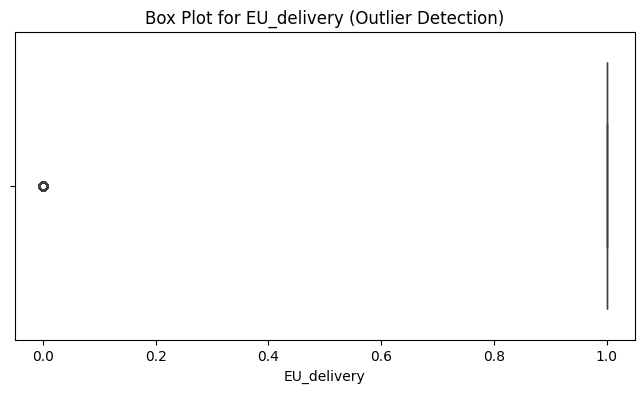

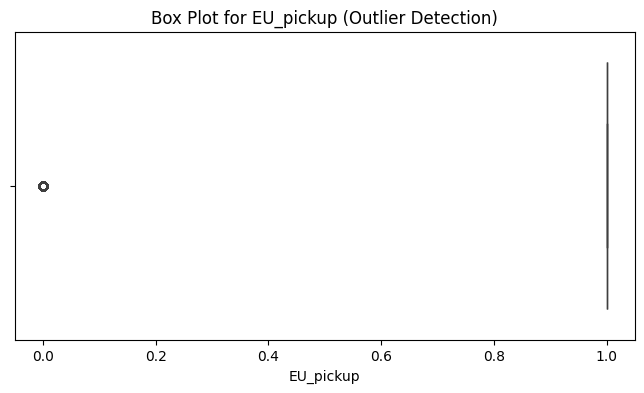

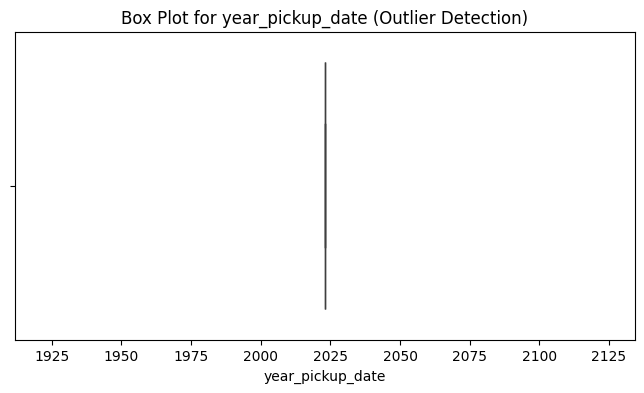

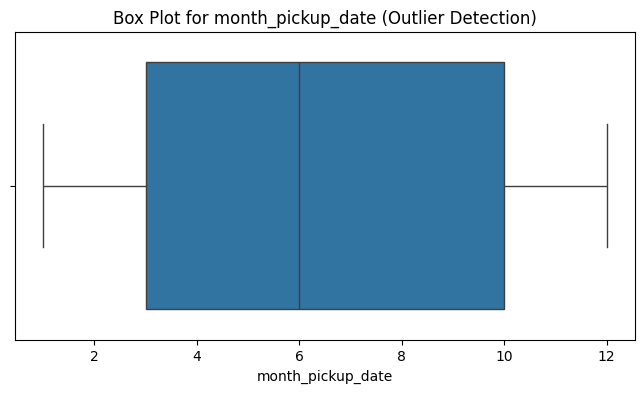

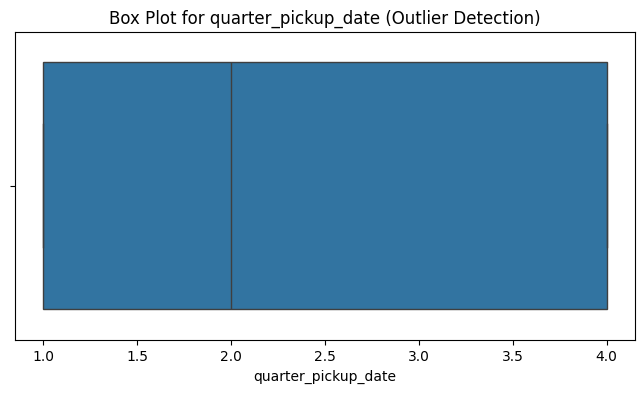

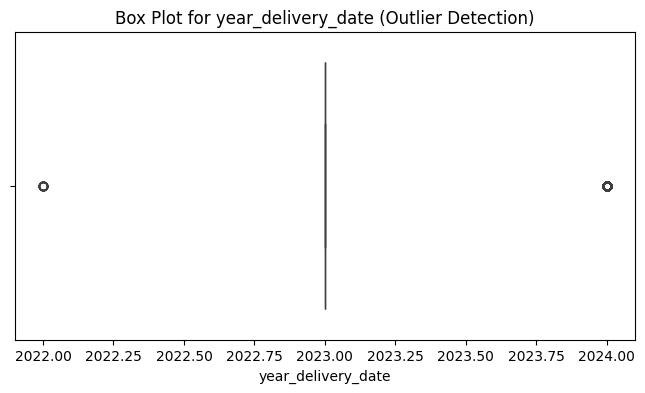

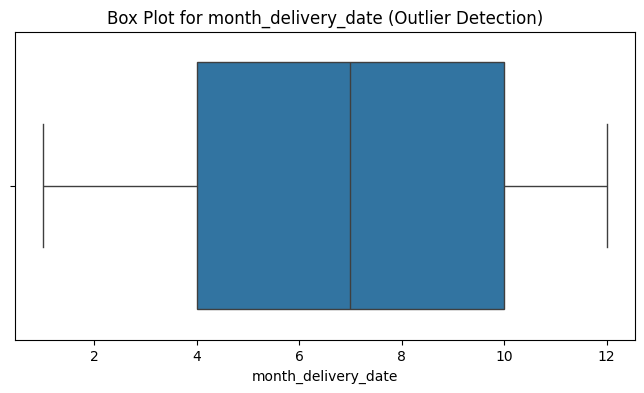

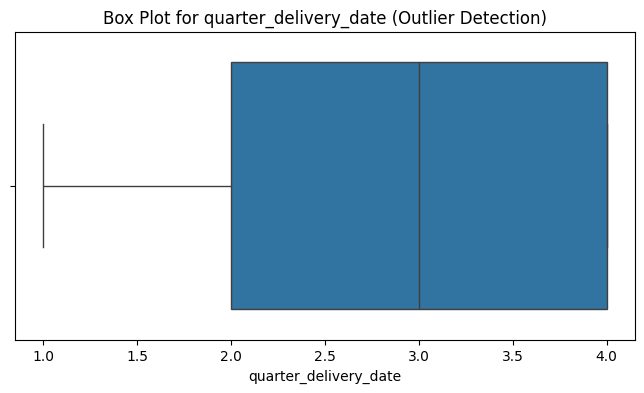

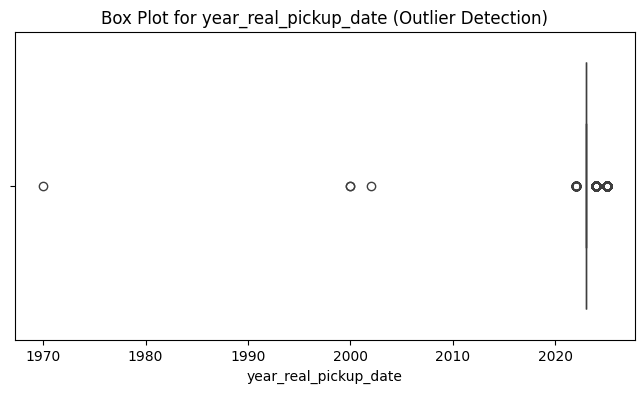

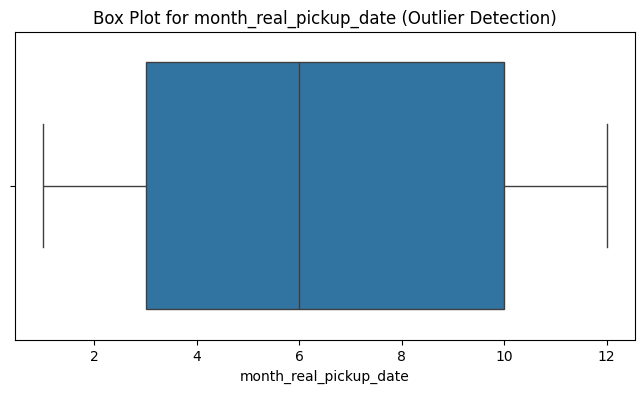

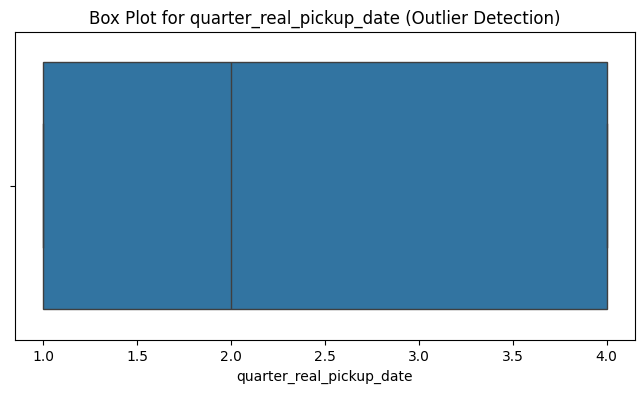

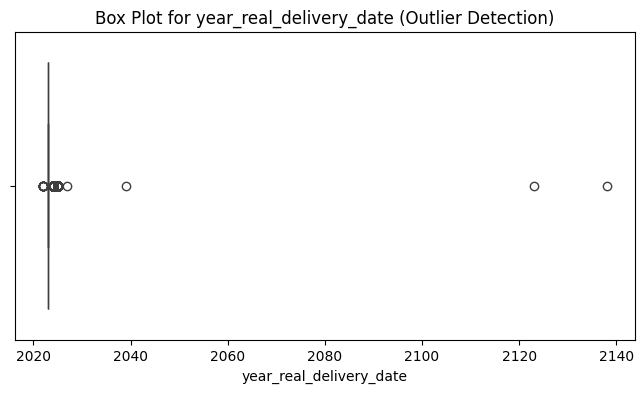

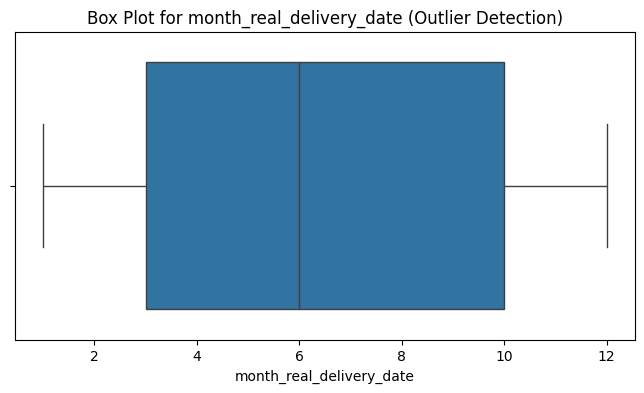

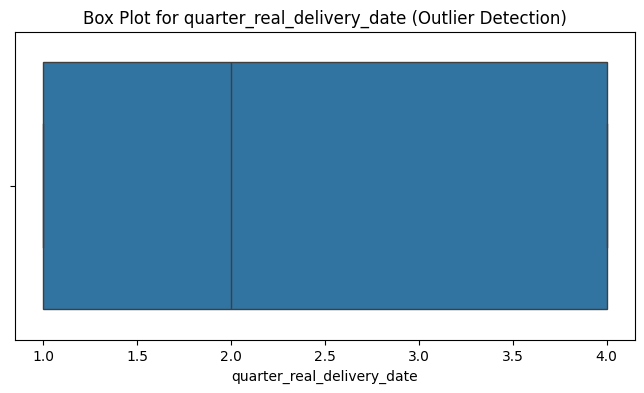

In [52]:
# Box plot for outlier detection in each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot for {feature} (Outlier Detection)")
    plt.xlabel(feature)
    plt.show()

## Feature Interaction Plots

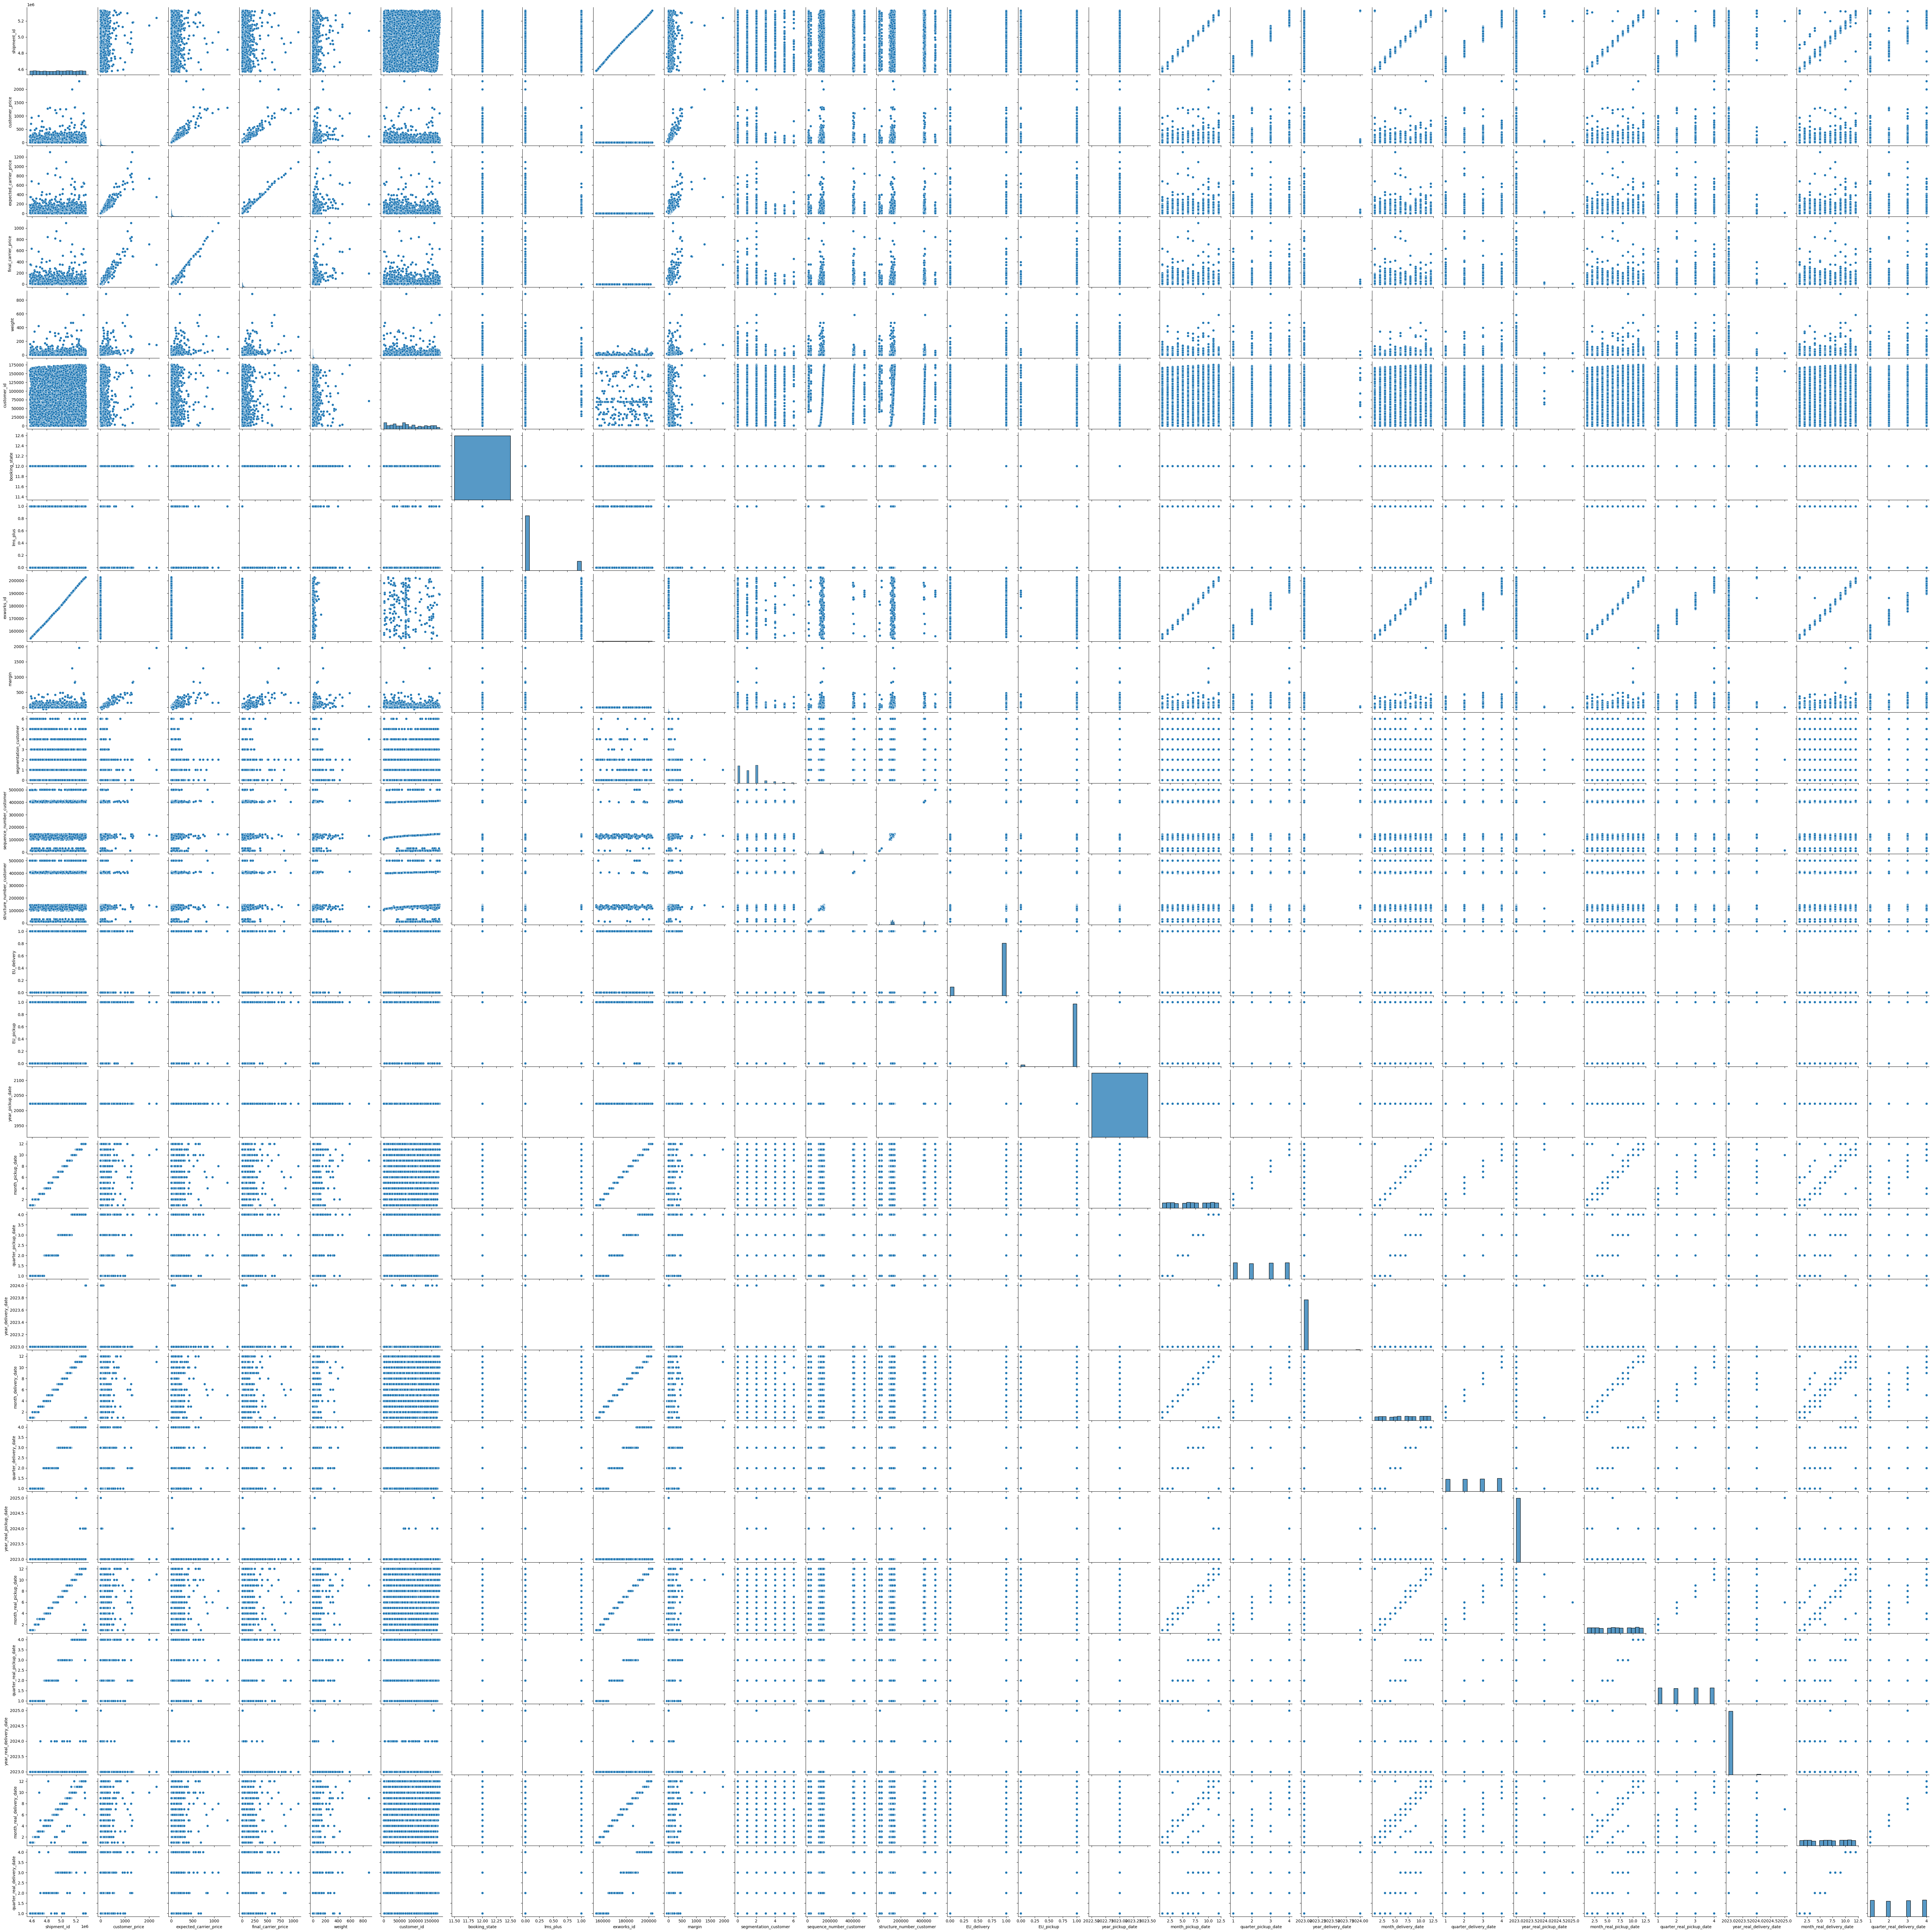

In [53]:
# Pair plot for numerical features (downsample to avoid overload if data is large)
sampled_data = df.sample(5000)  # Sample a subset to avoid overloading the plot
sns.pairplot(sampled_data[numerical_features])
plt.show()

## Target Variable Analysis

Very unbalanced for the last classes "Third_Country" and "Special".

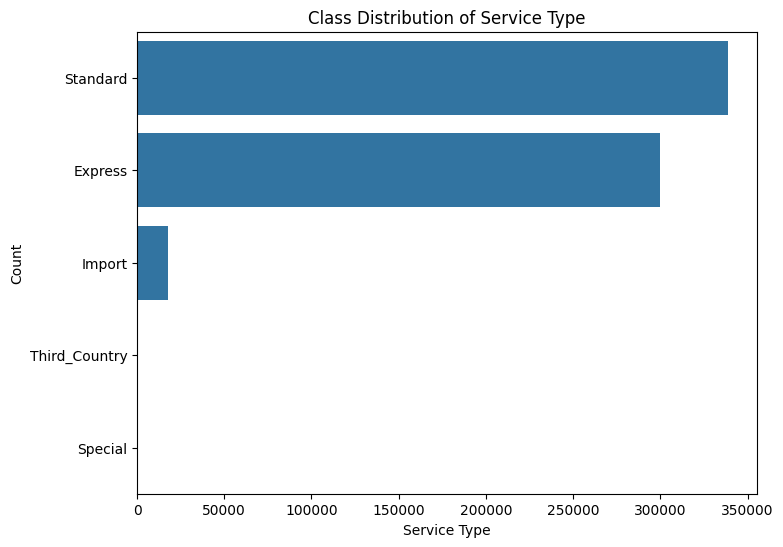

In [54]:
# Plotting the class distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(df['service_type'])
plt.title("Class Distribution of Service Type")
plt.xlabel("Service Type")
plt.ylabel("Count")
plt.show()

### Special class of the service type

In [55]:
# Filter out the 'special' class cases
special_cases = df[df['service_type'] == 'Special']

In [56]:
special_cases

shipment_id  customer_price  expected_carrier_price  \
59830       4666205          900.00                  621.00   
313849      4924433          768.94                  569.59   
513304      5164954           63.18                   30.46   
591447      5255438           22.47                   17.97   
628497      5298642          396.00                  246.00   
642599      5314951          240.00                  171.88   
643246      5315679           20.46                   14.27   

        final_carrier_price  weight shipment_type   insurance_type  \
59830                621.00     1.2        Parcel     No_Insurance   
313849               276.45   130.0        Parcel  Basic_Insurance   
513304                24.71     2.0        Parcel     No_Insurance   
591447                15.74     5.8        Parcel     No_Insurance   
628497                65.00     1.1        Parcel     No_Insurance   
642599               171.88     1.0      Document     No_Insurance   
643246                14.27     1.5        Parcel     No_Insurance   

        customer_id domain_name  booking_state  ...  quarter_pickup_date  \
59830         12353          DE             12  ...                    1   
313849       162869          FR             12  ...                    2   
513304        57632          DE             12  ...                    4   
591447       175117          FR             12  ...                    4   
628497         1632          DE             12  ...                    4   
642599       157529          FR             12  ...                    4   
643246       162748          FR             12  ...                    4   

        year_delivery_date  month_delivery_date quarter_delivery_date  \
59830                  NaN                  NaN                   NaN   
313849                 NaN                  NaN                   NaN   
513304                 NaN                  NaN                   NaN   
591447                 NaN                  NaN                   NaN   
628497                 NaN                  NaN                   NaN   
642599              2023.0                 12.0                   4.0   
643246                 NaN                  NaN                   NaN   

       year_real_pickup_date month_real_pickup_date  quarter_real_pickup_date  \
59830                   2023                      2                         1   
313849                  2023                      6                         2   
513304                  2023                     10                         4   
591447                  2023                     11                         4   
628497                  2024                      1                         1   
642599                  2023                     12                         4   
643246                  2023                     12                         4   

        year_real_delivery_date  month_real_delivery_date  \
59830                      2023                         2   
313849                     2023                         6   
513304                     2023                        10   
591447                     2023                        11   
628497                     2024                         1   
642599                     2023                        12   
643246                     2023                        12   

        quarter_real_delivery_date  
59830                            1  
313849                           2  
513304                           4  
591447                           4  
628497                           1  
642599                           4  
643246                           4  

[7 rows x 52 columns]

Special Cases Analysis:
        shipment_id  customer_price  expected_carrier_price  \
count  7.000000e+00        7.000000                7.000000   
mean   5.134329e+06      344.435714              238.738571   
std    2.487678e+05      362.893056              259.041222   
min    4.666205e+06       20.460000               14.270000   
25%    5.044694e+06       42.825000               24.215000   
50%    5.255438e+06      240.000000              171.880000   
75%    5.306796e+06      582.470000              407.795000   
max    5.315679e+06      900.000000              621.000000   

       final_carrier_price      weight    customer_id  booking_state  \
count             7.000000    7.000000       7.000000            7.0   
mean            169.864286   20.371429  104268.571429           12.0   
std             221.704823   48.371090   77317.241218            0.0   
min              14.270000    1.000000    1632.000000           12.0   
25%              20.225000    1.150000   34992.5

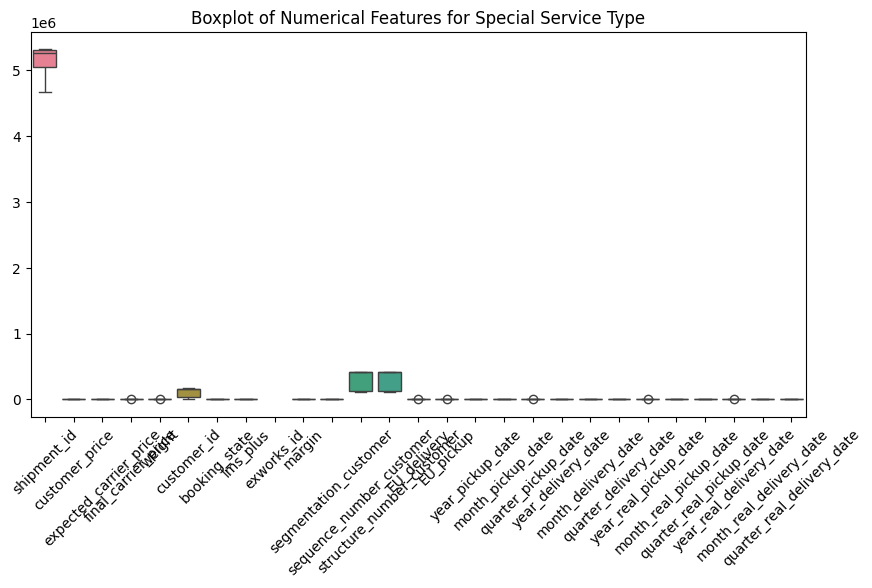

In [57]:
# Plot distribution for each numerical feature
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Display the special cases
print("Special Cases Analysis:")
print(special_cases.describe())  # General statistics for numerical features
print(special_cases.head())  # View the first few rows of the special cases

# Plot some of the key features for visual analysis
plt.figure(figsize=(10, 5))
sns.boxplot(data=special_cases[numerical_features])
plt.title('Boxplot of Numerical Features for Special Service Type')
plt.xticks(rotation=45)
plt.show()

### Margin comparison

As we can see, the margin for the "Special" class of the target variable is **higher**.

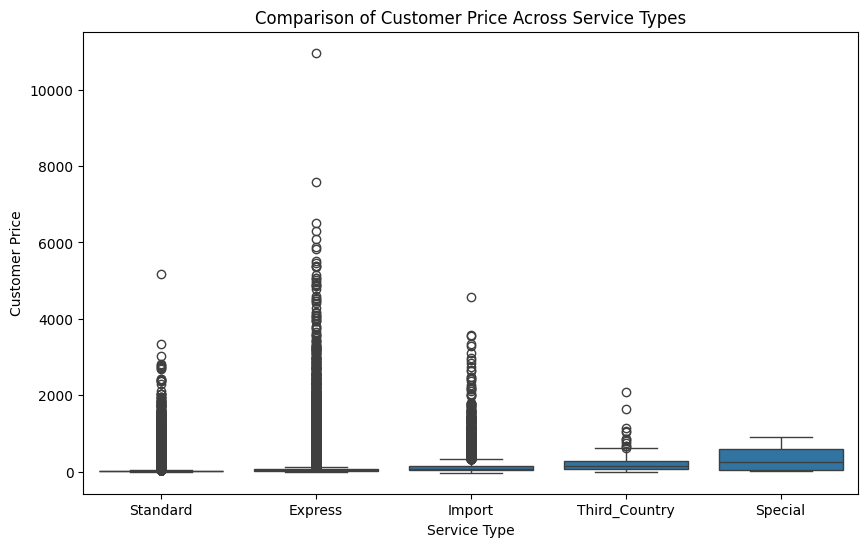

In [58]:
# Compare the customer price of 'special' cases with all other classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='service_type', y='customer_price', data=df)
plt.title('Comparison of Customer Price Across Service Types')
plt.xlabel('Service Type')
plt.ylabel('Customer Price')
plt.show()

In [59]:
# Create a new dataframe with derived margin
df_margin_analysis = df[['service_type', 'customer_price', 'final_carrier_price', 'expected_carrier_price']]

# Derive margin estimate as customer_price - final_carrier_price or expected_carrier_price if final_carrier_price is not available
df_margin_analysis['derived_margin'] = df_margin_analysis['customer_price'] - df_margin_analysis['final_carrier_price'].fillna(df_margin_analysis['expected_carrier_price'])

<ipython-input-59-427fc438419c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_margin_analysis['derived_margin'] = df_margin_analysis['customer_price'] - df_margin_analysis['final_carrier_price'].fillna(df_margin_analysis['expected_carrier_price'])


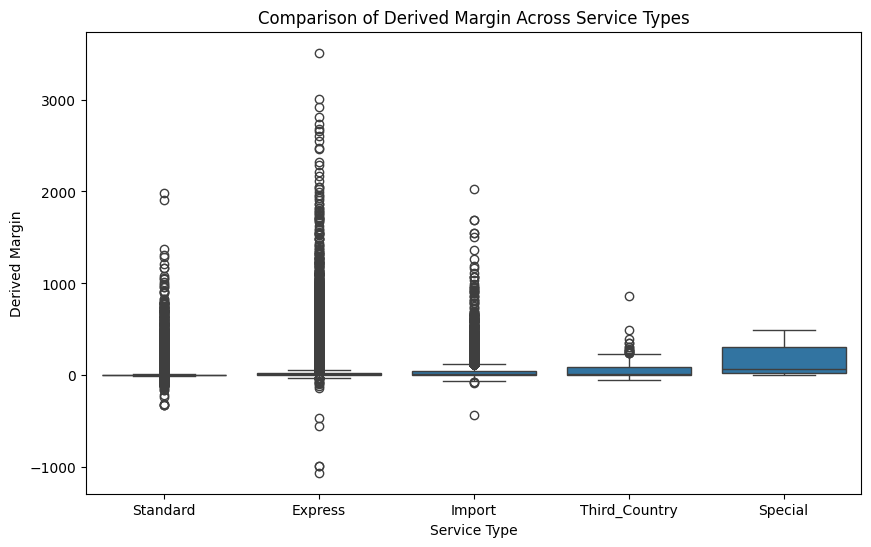

In [60]:
# Compare the derived margin of 'special' cases with all other classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='service_type', y='derived_margin', data=df_margin_analysis)
plt.title('Comparison of Derived Margin Across Service Types')
plt.xlabel('Service Type')
plt.ylabel('Derived Margin')
plt.show()

## Feature Importance Analysis (initial)

Analyze the feature importance before the preprocessing.

The feature importance will also be used later to have a better view after the preprocessing.

*Note*: For the categorical variables, we apply the One-Hot Encoding for the columns with less than 10 classes, while we apply "Label Encoding" for the ones with a higher count.

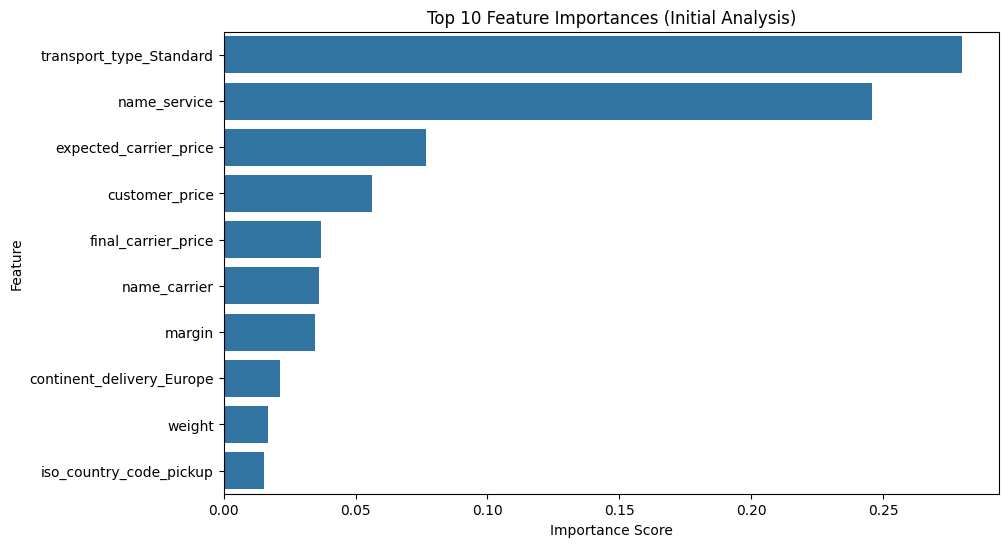

In [61]:
# Downsample the data to avoid memory overload
df_sampled = df.sample(frac=0.1, random_state=42)  # Use only 10% of the data

# Separate the target column before any transformations
target_column = 'service_type'
y = df_sampled[target_column]

# Drop the target column from the feature set
X = df_sampled.drop(columns=[target_column])

# Split numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Handle categorical columns
for col in categorical_cols:
    if X[col].nunique() > 10:  # High cardinality threshold (e.g., > 10 unique values)
        # Apply Label Encoding for high-cardinality features
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        # Apply One-Hot Encoding for low-cardinality features
        X = pd.get_dummies(X, columns=[col], drop_first=True)

# Encode categorical target column if not already encoded
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

# Train a RandomForestClassifier for feature importance analysis
rf = RandomForestClassifier(n_estimators=20, random_state=42)  # Reduced number of estimators to limit memory usage
rf.fit(X, y)

# Plot feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances (Initial Analysis)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Correlation with Target Variable

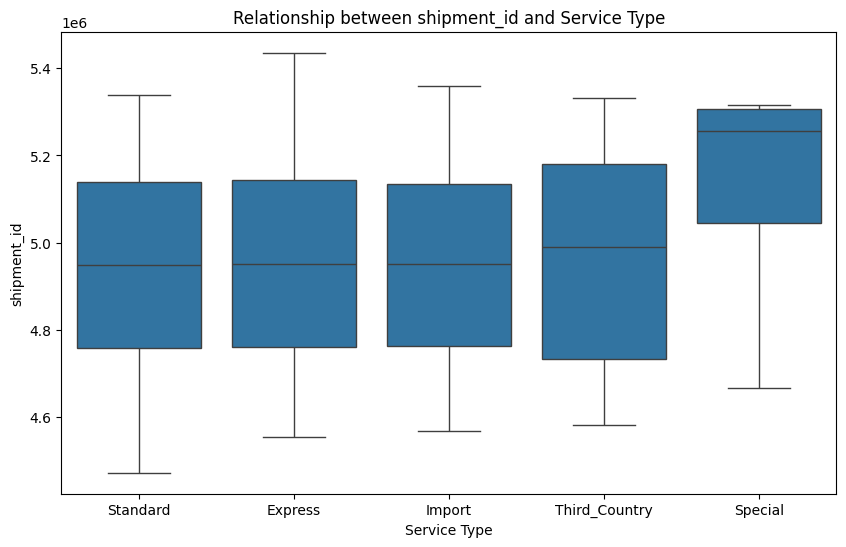

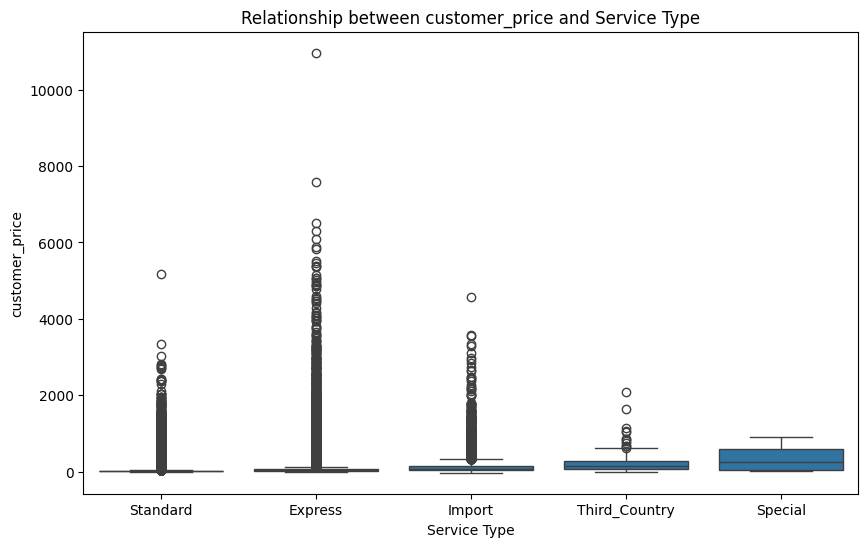

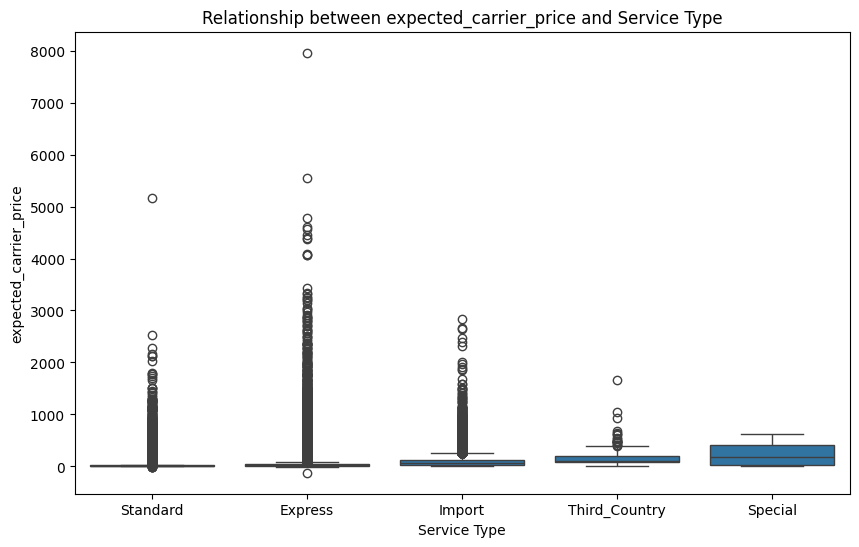

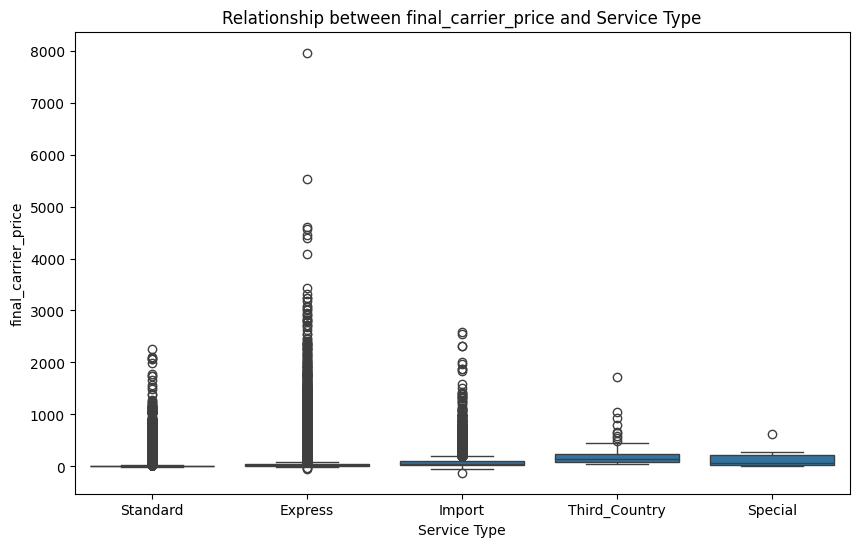

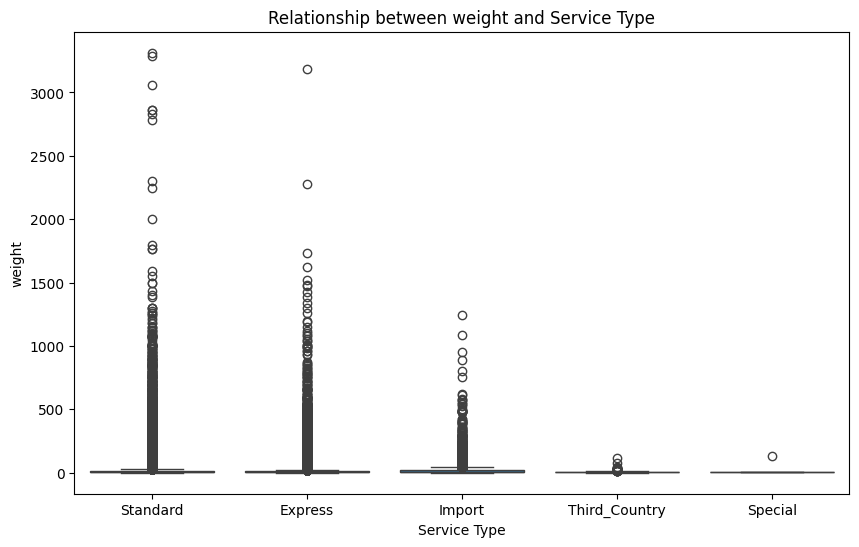

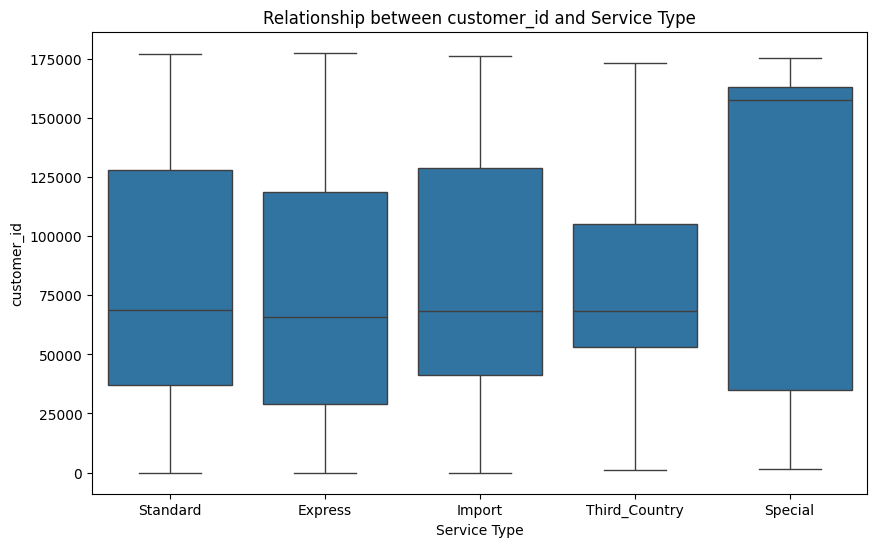

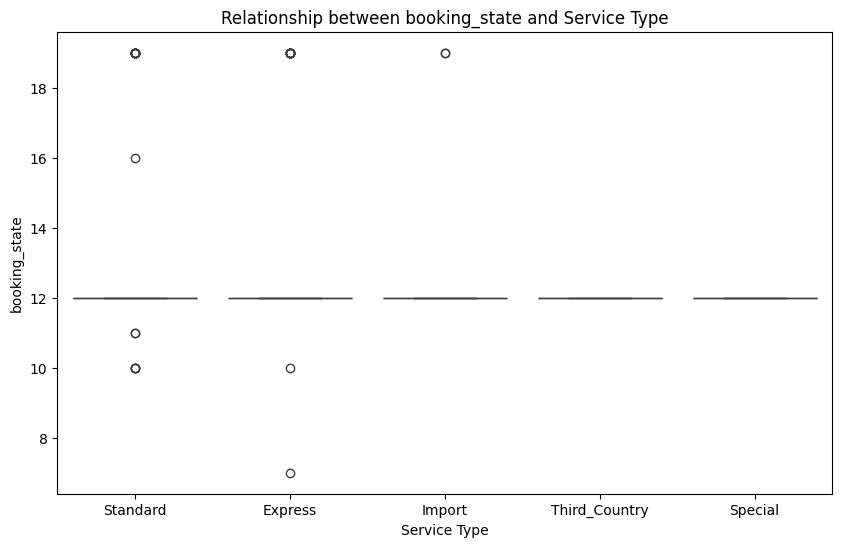

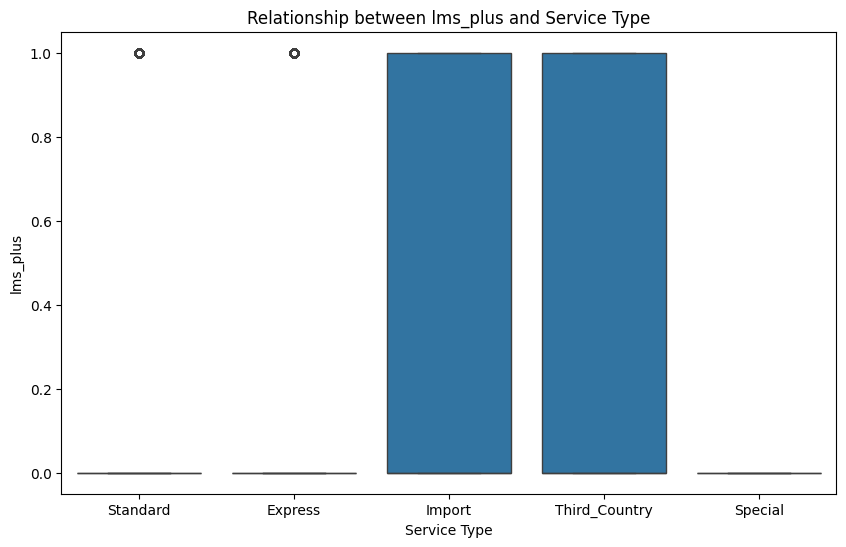

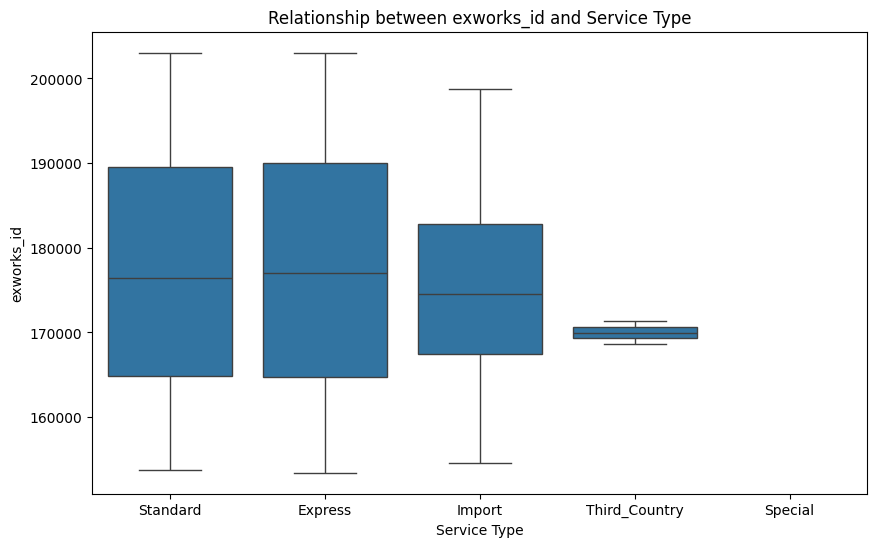

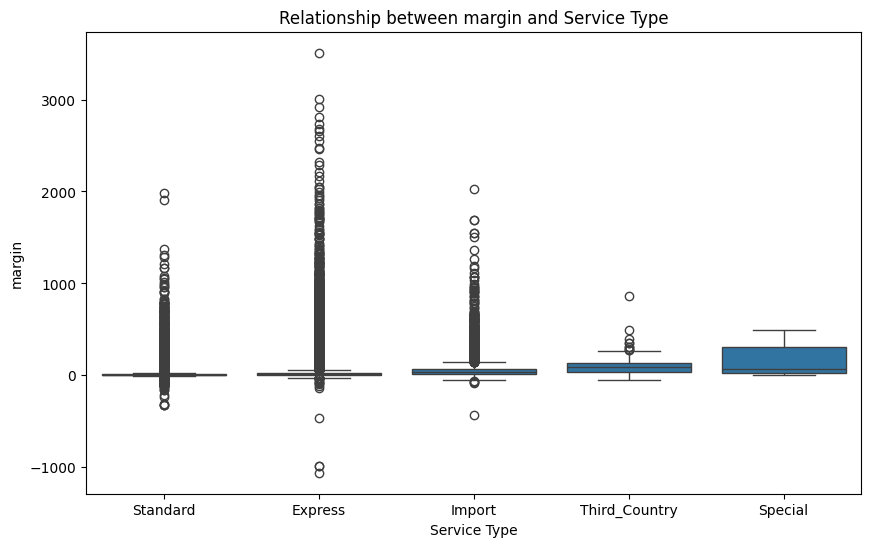

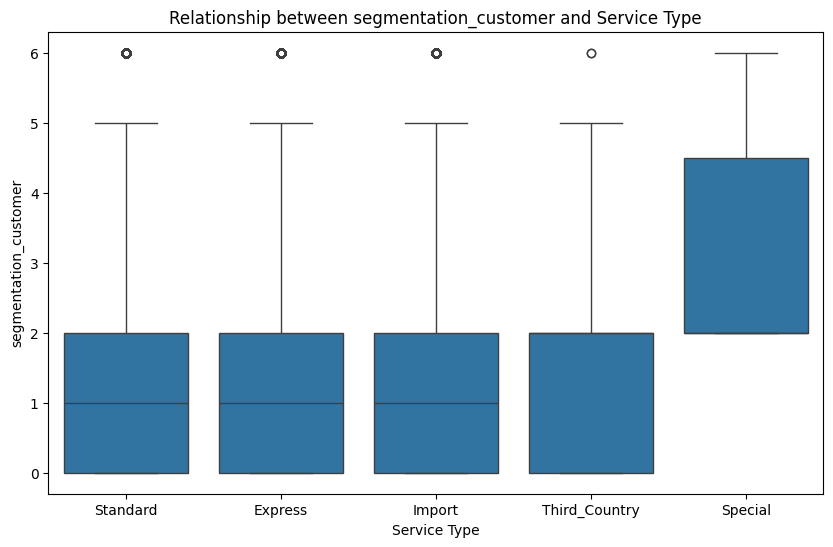

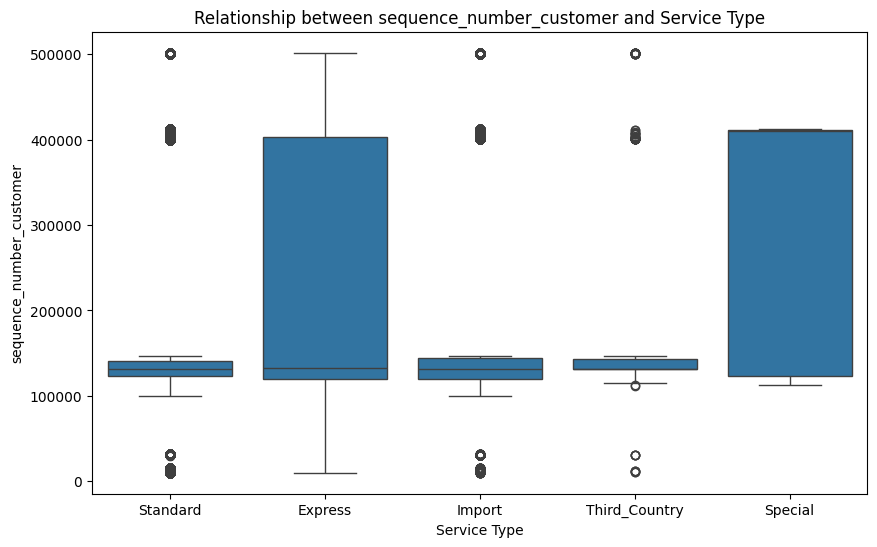

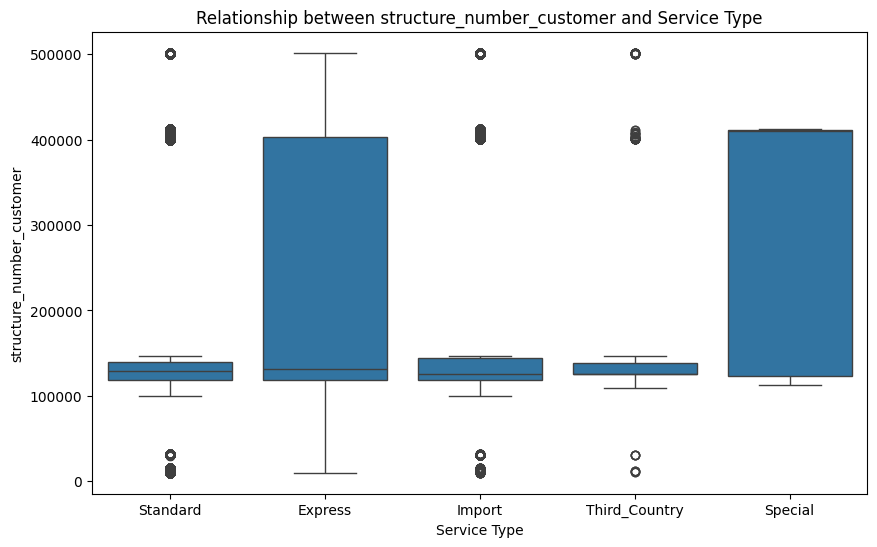

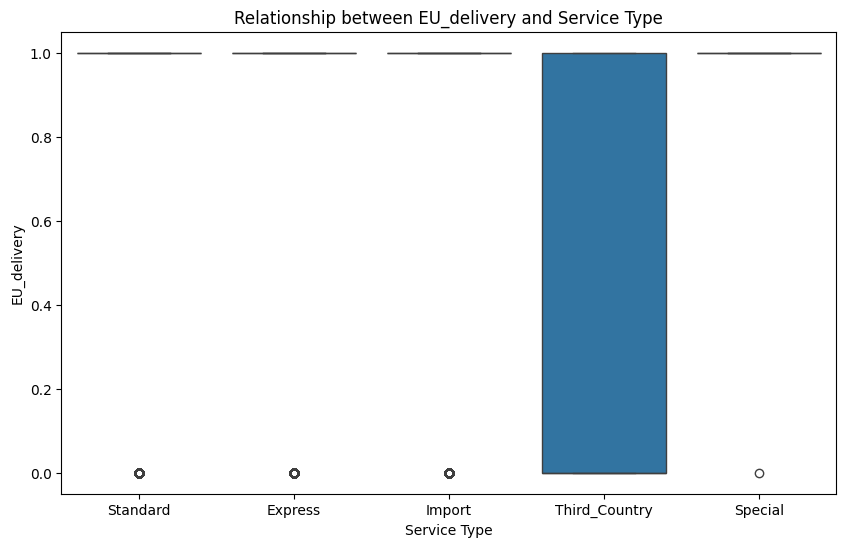

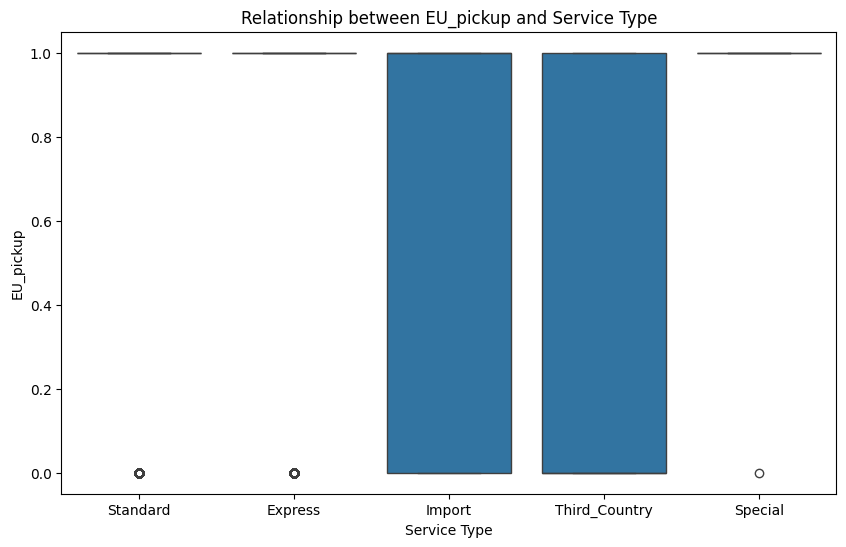

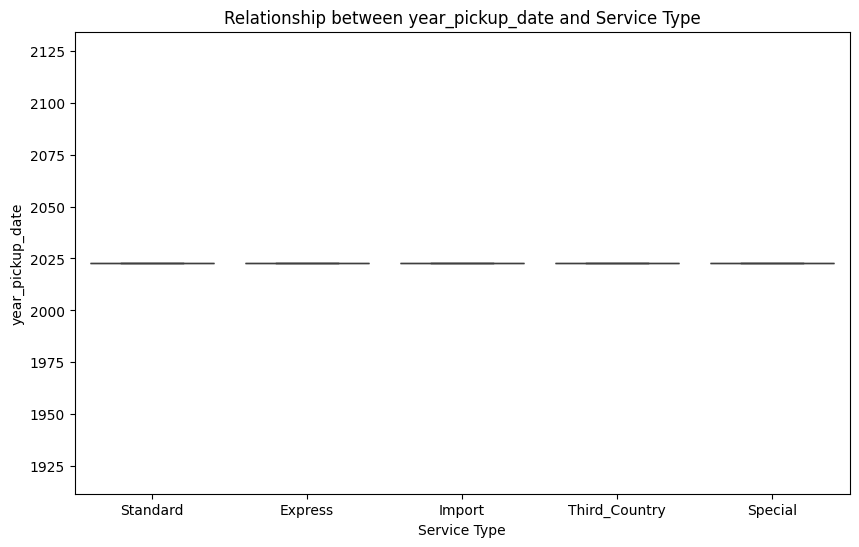

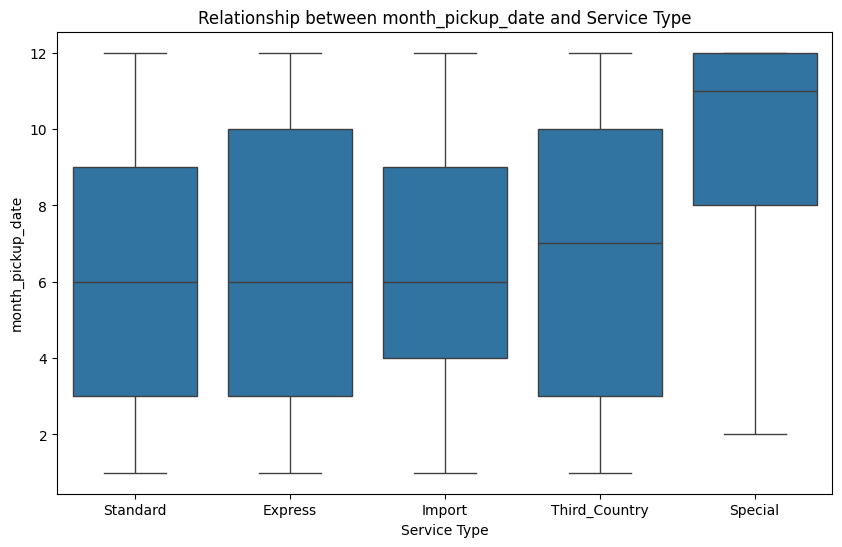

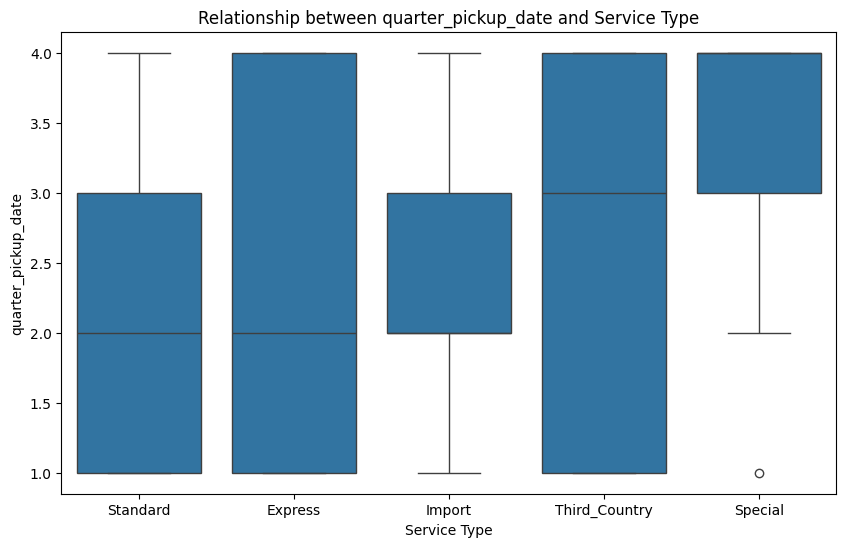

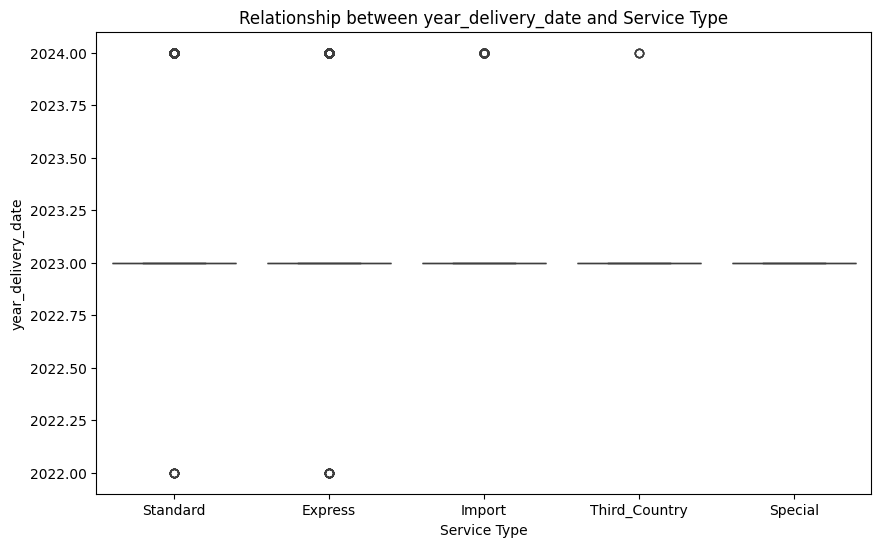

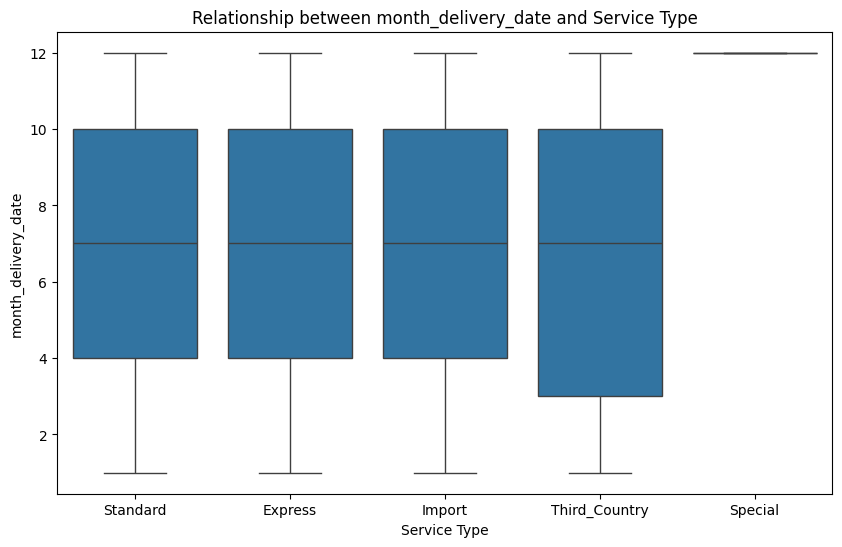

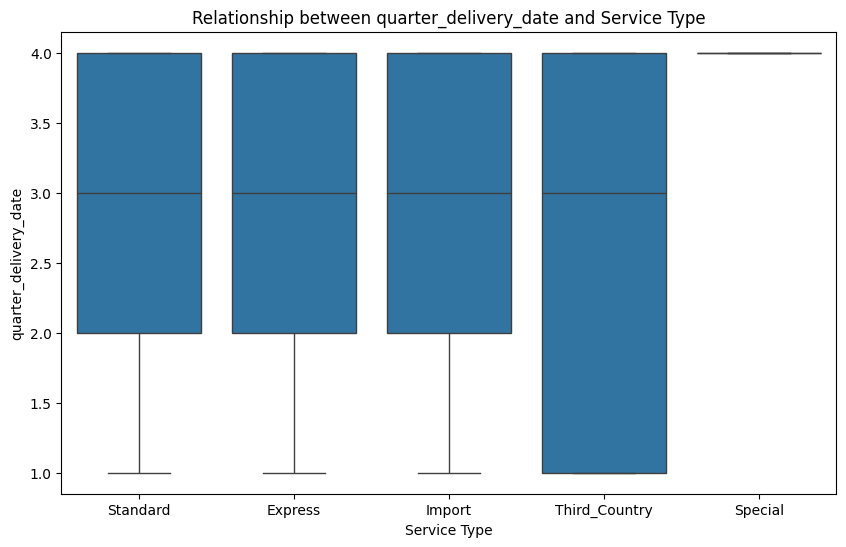

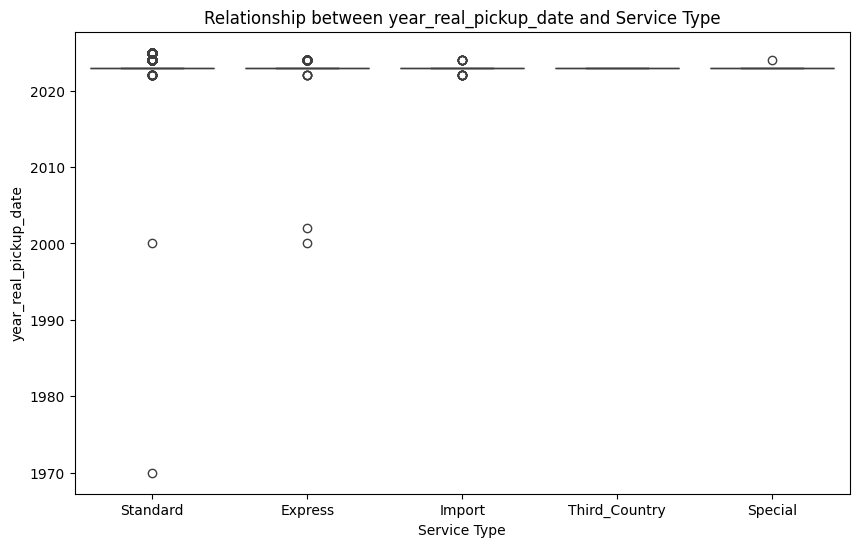

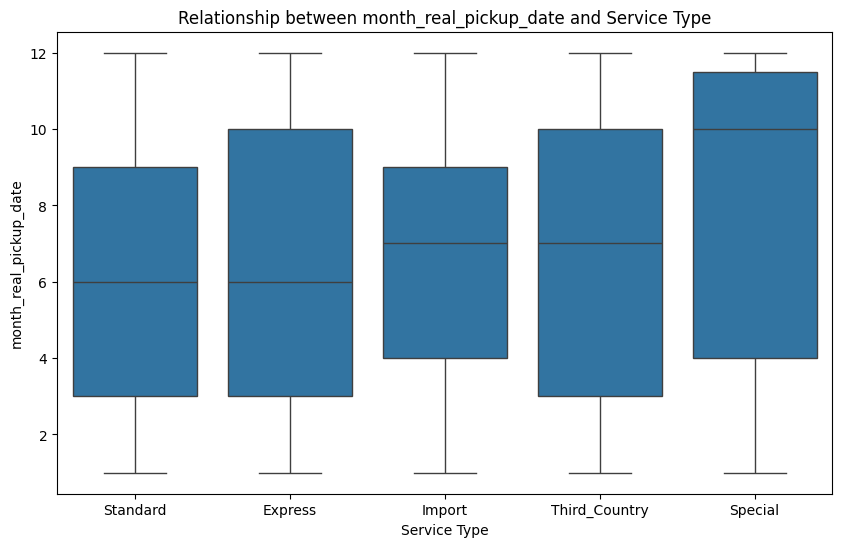

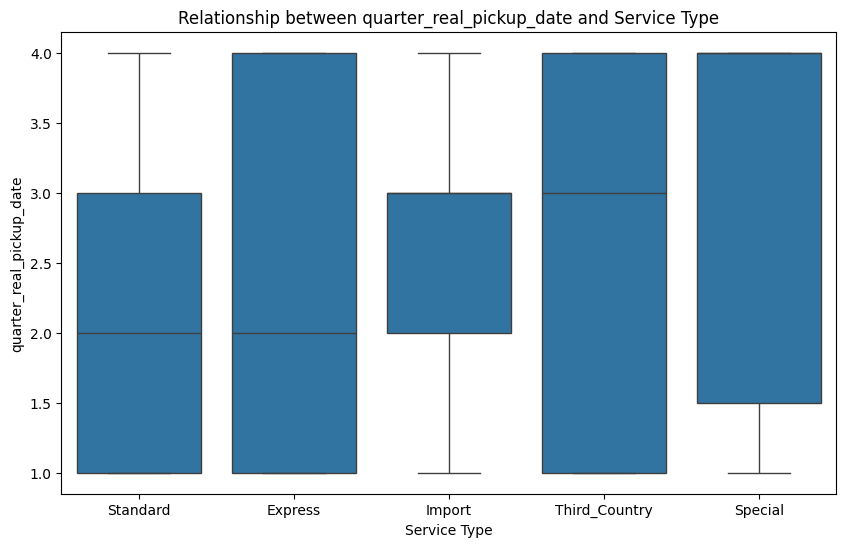

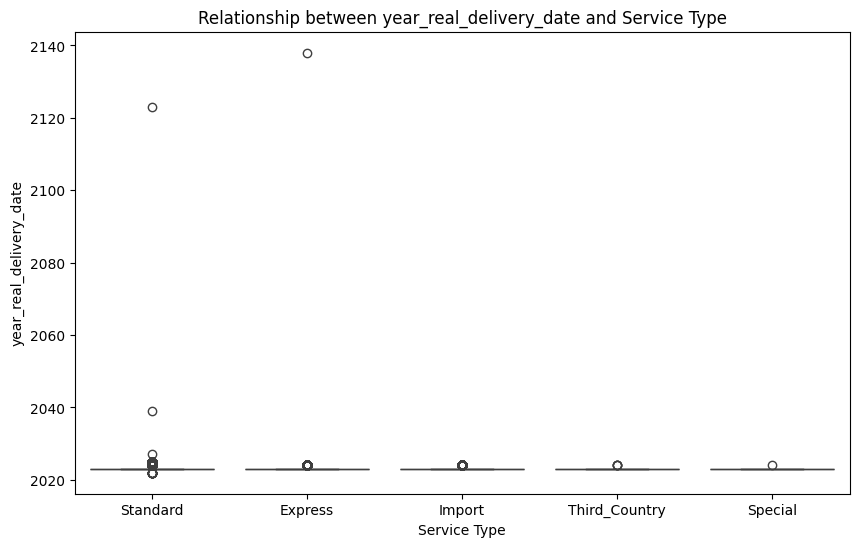

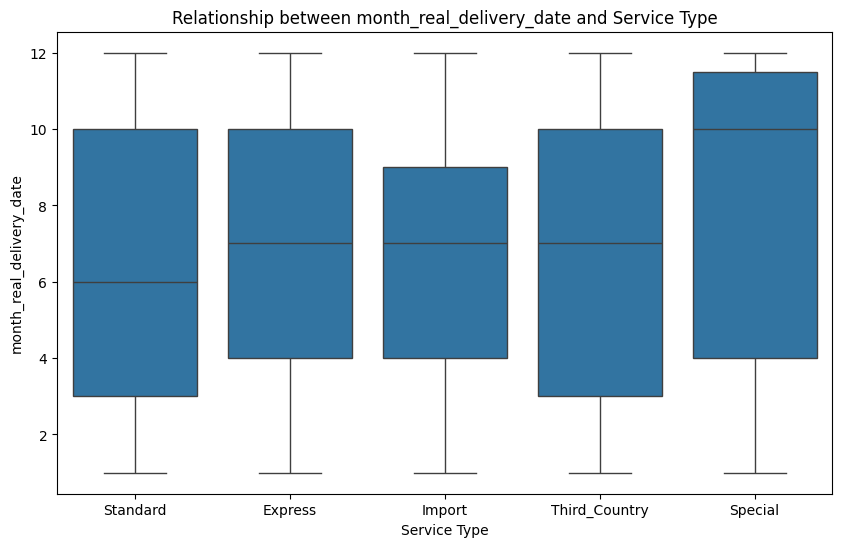

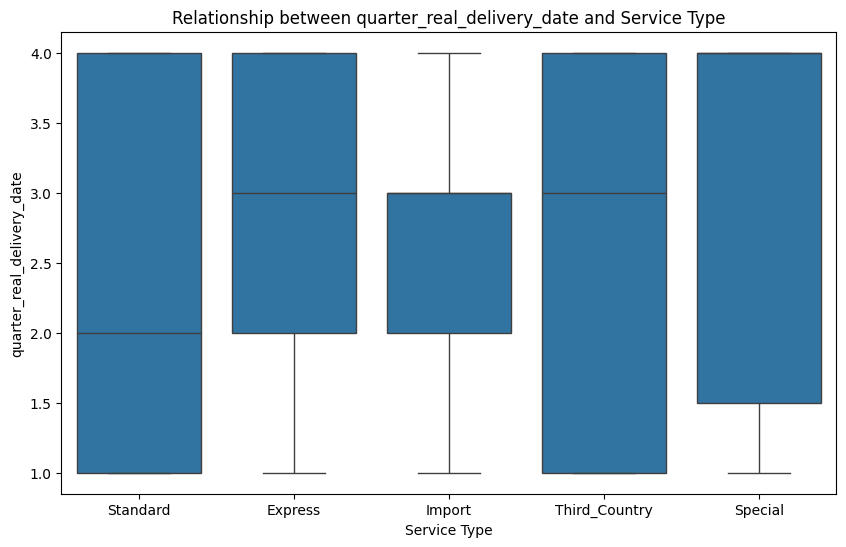

In [62]:
# Box plots to see how numerical features relate to the target variable
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['service_type'], y=df[feature])
    plt.title(f"Relationship between {feature} and Service Type")
    plt.xlabel("Service Type")
    plt.ylabel(feature)
    plt.show()

# Preprocessing

In this phase, we treat everything we identified in the previous step.

## Removing unavailable columns at the moment of the prediction

These are the columns that aren't avaiable when making the prediction, so they represent something akin to "Target Leakage".

In [63]:
columns_to_exclude = [
    'year_delivery_date', 'month_delivery_date',
    'quarter_delivery_date', 'year_real_delivery_date',
    'month_real_delivery_date', 'quarter_real_delivery_date',
    'final_carrier_price',
    'margin',
    'year_pickup_date', 'month_pickup_date', 'quarter_pickup_date',
    'year_real_pickup_date', 'month_real_pickup_date', 'quarter_real_pickup_date',
    'domain_name_service',
    'domain_name_customer',
    'transport_type', 'shipment_id',
    'name_service'
]

In [64]:
# Drop the identified columns to prevent label leakage
df = df.drop(columns=columns_to_exclude, axis=1)

## Handling missing values

To handle the missing values, we approached this problem in the following way:
- For the **numerical features**, we replaced them with the median, given the high number of outliers.
- For the **categorical features**, we replaced them with the value *missing*, which we intentionally wanted to introduce as a "new value" to represent the fact that the feature is missing.

In [65]:
# columns with NAs (with more than 0)
df.isna().sum()[df.isna().sum() > 0]

exworks_id                       630942
main_industry_name_customer      199023
industry_sector_name_customer    199023
segmentation_customer            109702
postal_code_delivery              14071
name_country_delivery             27321
iso_country_code_delivery         27341
continent_delivery                27321
EU_delivery                       27321
postal_code_pickup                 1116
city_pickup                           1
name_country_pickup                1637
iso_country_code_pickup            1637
continent_pickup                   1637
EU_pickup                          1637
dtype: int64

In [66]:
# Drop columns with too many missing values (more than 70% missing)
threshold = len(df) * 0.7
df = df.dropna(axis=1, thresh=threshold)

# Fill numeric columns with median and categorical columns with 'missing'
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('missing')

## Feature Encoding

As mentioned before, we use the **One-Hot Encoding** for features with less than 10 classes, while we use the **Label Encoding** for the others that have a higher count.

In [67]:
# Split Features and Target
X = df.drop(["service_type"], axis=1)
y = df["service_type"]

In [68]:
# Encoding Strategy for Features
# Split categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Apply Encoding to Categorical Features
# Label Encoding for high-cardinality features, One-Hot Encoding for low-cardinality features
for col in categorical_cols:
    if X[col].nunique() > 10:  # High cardinality threshold (e.g., >10 unique values)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X = pd.get_dummies(X, columns=[col], drop_first=True)

## Train Test Split, SMOTE, and Scaling

Here we perform the *train_test_split* in a custom way.

In fact, in this phase, we:
1. Split the dataset in train and test (using 80% / 20% division), considering the **stratify** parameter to leave the same distributions of the target variable.
2. Made sure that the classes "Special" and "Third_Country" have at least 3 cases in the test dataset, in order to be sure that we have something to eventually try to predict.
3. Apply SMOTE for the classes "Special" and "Third_Country" in the *training dataset* (not in the test dataset) to make at least a bit more balanced the cases.
4. Scale the features using a **Standard Scaler**.


*Note*: We didn't remove the outliers, because after testing them, it seemed that the model performed worse, meaning that in this dataset, the outliers, actually had an important meaning.

In [135]:
def ensure_minimum_class_samples(X_train, X_test, y_train, y_test, special_classes_encoded, min_samples=3):
    """
    Ensure at least `min_samples` of each special class in the test set by transferring samples
    from the training set to the test set.
    """
    y_train, y_test = pd.Series(y_train, index=X_train.index), pd.Series(y_test, index=X_test.index)

    for special_class_encoded in special_classes_encoded:
        special_test_count = sum(y_test == special_class_encoded)
        if special_test_count < min_samples:
            additional_test_needed = min_samples - special_test_count
            special_train_indices = y_train[y_train == special_class_encoded].index[:additional_test_needed]

            if len(special_train_indices) > 0:
                X_test = pd.concat([X_test, X_train.loc[special_train_indices]])
                y_test = pd.concat([y_test, y_train.loc[special_train_indices]])
                X_train = X_train.drop(special_train_indices)
                y_train = y_train.drop(special_train_indices)
            else:
                print(f"Not enough samples of class {special_class_encoded} in training set to meet the test set requirement.")

    return X_train, X_test, y_train.values, y_test.values

In [125]:
def calculate_sampling_strategy(y, special_classes_encoded, max_synthetic):
    """
    Calculate the sampling strategy for SMOTE based on the target counts.
    """
    sampling_strategy = {}
    for special_class_encoded in special_classes_encoded:
        class_count = sum(y == special_class_encoded)
        if class_count > 1:  # SMOTE requires at least 2 samples
            sampling_strategy[special_class_encoded] = min(max_synthetic, max(1000, class_count))
    return sampling_strategy

In [126]:
def apply_smote(X, y, sampling_strategy, random_state=42):
    """
    Apply SMOTE to balance the classes.
    """
    if sampling_strategy:
        k_neighbors = max(1, min(5, min([sum(y == c) - 1 for c in sampling_strategy.keys()])))
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
        return smote.fit_resample(X, y)
    return X, y

In [127]:
def scale_features(X_train, X_test, numerical_cols):
    """
    Scale numerical features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    return X_train_scaled, X_test_scaled

In [136]:
def custom_train_test_split(
    X, y, special_classes=["Special", "Third_Country"], test_size=0.2, max_synthetic=1000, random_state=42
):
    """
    Perform a stratified train-test split, apply SMOTE for specified classes, and scale features.
    """
    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    special_classes_encoded = label_encoder.transform(special_classes)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    # Ensure minimum samples for each special class in the test set
    X_train, X_test, y_train, y_test = ensure_minimum_class_samples(
        X_train, X_test, y_train, y_test, special_classes_encoded
    )

    # Calculate SMOTE sampling strategy
    sampling_strategy = calculate_sampling_strategy(y_train, special_classes_encoded, max_synthetic)

    # Apply SMOTE to balance the classes
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train, sampling_strategy, random_state)

    # Scale features
    numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
    X_train_scaled, X_test_scaled = scale_features(X_train_resampled, X_test, numerical_cols)

    # Decode the labels for output consistency
    y_train_resampled_decoded = label_encoder.inverse_transform(y_train_resampled)
    y_test_decoded = label_encoder.inverse_transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_resampled_decoded, y_test_decoded

In [137]:
X_train, X_test, y_train, y_test = custom_train_test_split(
    X, y, special_classes=["Special", "Third_Country"], test_size=0.2, max_synthetic=1000, random_state=42
)

In [138]:
# Check the shapes
print(f"X_train: {X_train.shape}, y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}, y_test: {len(y_test)}")

X_train: (527223, 58), y_train: 527223
X_test: (131363, 58), y_test: 131363


In [139]:
print(f"Special Class in y_train: {len(y_train[y_train == 'Special'])}")
print(f"Special Class in y_test: {len(y_test[y_test == 'Special'])}")
print(f"Third_Country Class in y_train: {len(y_train[y_train == 'Third_Country'])}")
print(f"Third_Country Class in y_test: {len(y_test[y_test == 'Third_Country'])}")

Special Class in y_train: 1000
Special Class in y_test: 3
Third_Country Class in y_train: 1000
Third_Country Class in y_test: 53


## Feature selection

Using the feature importance from the Random Forest, we include in the dataset, only the 10 features with the highest importance.

Selected Features: ['customer_price', 'expected_carrier_price', 'weight', 'customer_id', 'segmentation_customer', 'sequence_number_customer', 'structure_number_customer', 'postal_code_delivery', 'city_delivery', 'name_country_delivery', 'iso_country_code_delivery', 'EU_delivery', 'postal_code_pickup', 'city_pickup', 'name_country_pickup', 'iso_country_code_pickup', 'name_carrier', 'shipment_type_Parcel', 'continent_delivery_Europe', 'continent_pickup_Europe']


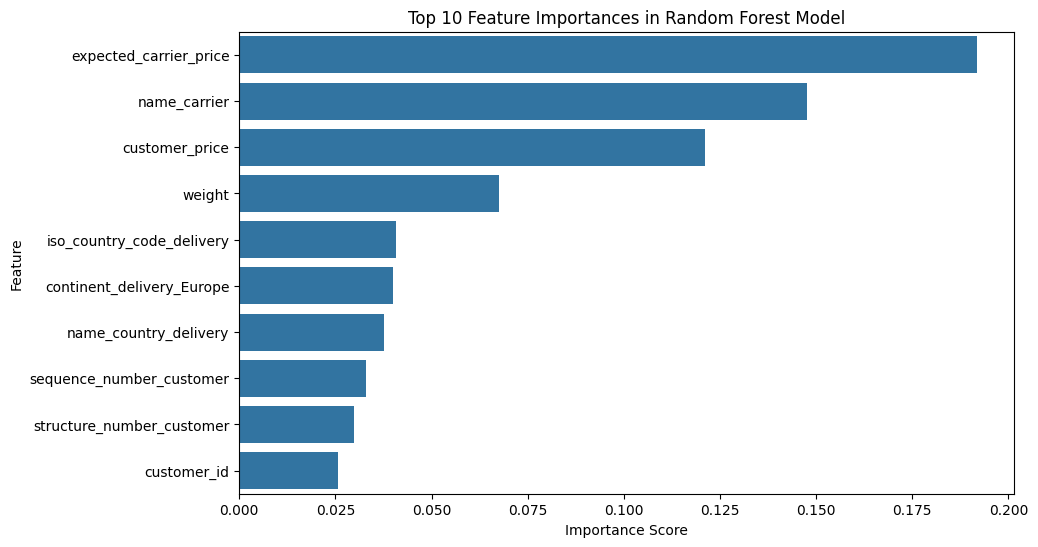

In [77]:
# Random Forest Feature Selection
# Train a RandomForestClassifier to determine feature importance
importance_rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced number of estimators for simplicity
importance_rf.fit(X_train, y_train)

# Get Feature Importances and Select Important Features
feature_importances = pd.Series(importance_rf.feature_importances_, index=X_train.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()  # Adjust threshold as needed

# Output the Selected Features
print("Selected Features:", important_features)

# Feature Importance Analysis (Top 10 from Selected Features)
selected_importances = feature_importances[important_features].sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_importances.values, y=selected_importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [140]:
# Create Final Dataset with Selected Features
X_selected_train = X_train[important_features]
X_selected_test = X_test[important_features]

# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics we use are:
- Accuracy.
- Cross-Validation Accuracy
- Cross-Validation Standard Deviation.
- ROC-AUC.

In [79]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [141]:
# Prepare training and test data
X_train, X_test = X_selected_train, X_selected_test
y_train, y_test = y_train, y_test

In [142]:
# Label encoding for target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [111]:
# Function to calculate and optionally plot ROC AUC
def calculate_roc_auc(y_test, y_pred_prob, model_name, plot=True):
    if y_pred_prob is not None and len(set(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        if plot:
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic for {model_name}')
            plt.legend(loc='lower right')
            plt.show()
        return roc_auc
    elif y_pred_prob is not None and len(set(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
        return roc_auc
    return None

In [83]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    print(f"{model_name} Cross-Validation Accuracy: {mean_cv:.4f} (+/- {std_cv:.4f})")

    # Train the model on the whole training dataset this time
    model.fit(X_train, y_train_encoded)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    if y_pred_prob is not None and y_pred_prob.shape[1] == 2:  # Binary case
        y_pred_prob = y_pred_prob[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test_encoded, y_pred)
    roc_auc = calculate_roc_auc(y_test_encoded, y_pred_prob, model_name)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Cross-Validation Accuracy": mean_cv,
        "Cross-Validation Std Dev": std_cv,
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
        "ROC AUC": roc_auc,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation Accuracy: 0.7086 (+/- 0.0011)

Model: Logistic Regression
Test Set Accuracy: 0.7066
ROC AUC: 0.8710
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67     60006
           1       0.36      0.75      0.49      3608
           2       0.00      0.00      0.00         1
           3       0.74      0.81      0.77     67693
           4       0.02      0.89      0.04        53

    accuracy                           0.71    131361
   macro avg       0.38      0.61      0.39    131361
weighted avg       0.74      0.71      0.72    131361

Confusion Matrix:
[[35115  2819   885 18873  2314]
 [  386  2711    44   412    55]
 [    1     0     0     0     0]
 [10068  2006   481 54949   189]
 [    1     4     1     0    47]]



Training Naive Bayes...
Naive Bayes Cross-Validation Accuracy: 0.6439 (+/- 0.0196)

Model: Naive Bayes
Test Set Accuracy: 0.6507
RO

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Random Forest
Test Set Accuracy: 0.9753
ROC AUC: 0.8987
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97     60006
           1       1.00      1.00      1.00      3608
           2       0.00      0.00      0.00         1
           3       0.98      0.97      0.98     67693
           4       1.00      0.89      0.94        53

    accuracy                           0.98    131361
   macro avg       0.79      0.77      0.78    131361
weighted avg       0.98      0.98      0.98    131361

Confusion Matrix:
[[58826     1     0  1179     0]
 [    7  3601     0     0     0]
 [    1     0     0     0     0]
 [ 2055     0     0 65638     0]
 [    3     3     0     0    47]]



Training XGBoost...
XGBoost Cross-Validation Accuracy: 0.9647 (+/- 0.0007)

Model: XGBoost
Test Set Accuracy: 0.9649
ROC AUC: 0.9838
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     60006
           1       1.00      1.00      1.00      3608
     

In [84]:
# Display summary results
results_df = pd.DataFrame({
    model: {
        "Test Accuracy": metrics["Accuracy"],
        "Cross-Val Accuracy": metrics["Cross-Validation Accuracy"],
        "ROC AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("\nSummary of Results:")
print(results_df)


Summary of Results:
                     Test Accuracy  Cross-Val Accuracy   ROC AUC
Logistic Regression       0.706618            0.708590  0.870982
Naive Bayes               0.650749            0.643906  0.807367
Decision Tree             0.960331            0.958600  0.861230
Random Forest             0.975267            0.974258  0.898731
XGBoost                   0.964898            0.964727  0.983769
LightGBM                  0.933755            0.930458  0.785463


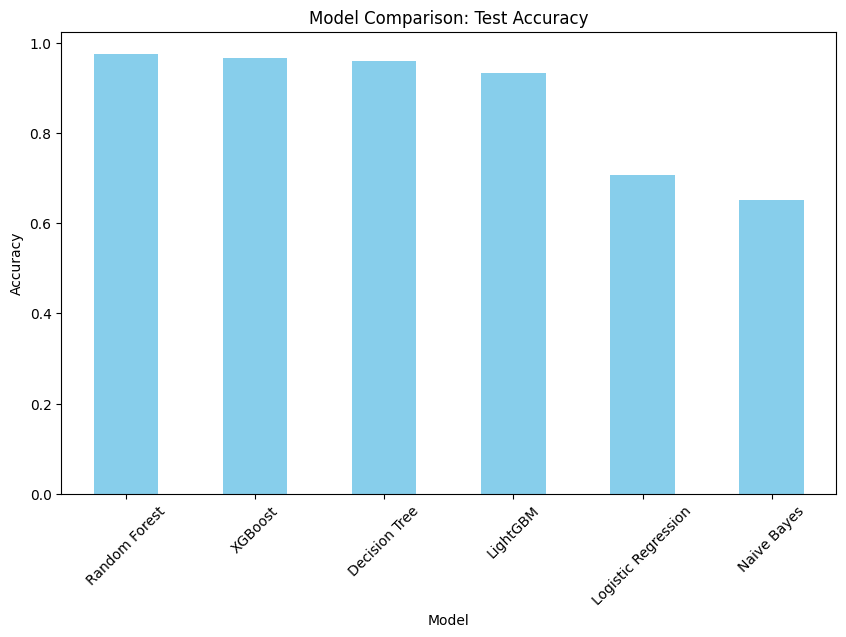

In [85]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Accuracy"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

# Analysis of Results

### Summary of Business Impact

The Random Forest model provides key insights for optimizing delivery services:
1. **Feature Importance**: The top features driving the predictions indicate which factors most impact the service type, providing insights into areas that can be optimized.
2. **Cost Matrix**: By analyzing the cost associated with false positives and false negatives, the model helps in understanding the financial implications of incorrect predictions. For example, reducing false positives might lower operational costs.
3. **Operational Efficiency**: By accurately predicting the service type, resources can be allocated more effectively, improving overall efficiency.
4. **Customer Targeting**: The insights from feature importance can help target specific customer segments with tailored services, increasing satisfaction and loyalty.

## Train best model

In [143]:
# Train the final Random Forest model
final_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
final_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_rf.predict(X_test)
y_pred_prob = final_rf.predict_proba(X_test)

## Compute metrics of performance

In [144]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)

In [147]:
# # Calculate ROC AUC for multiclass
# roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
# print(f"Overall Multiclass ROC AUC: {roc_auc:.4f}")

# # Plot ROC Curve
# plt.figure(figsize=(10, 6))
# for i in range(3):  # Adjust for number of classes
#     fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc_score(y_test == i, y_pred_prob[:, i]):.2f})')

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# # Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=final_rf.classes_, yticklabels=final_rf.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Random Forest')
# plt.show()

## Cost Matrix

For this analysis, we assume the following:
- FN Cost: \$100 (missing a "Special" shipment is highly costly).
- FP Cost: \$10 (mislabeling a regular shipment as "Special" has moderate cost).
- TN/TP Cost: \$0 (correct predictions have no penalty).

In [100]:
# Updated Cost Matrix Analysis
cost_matrix = np.array([[0, 10],
                        [100, 0]])  # Costs: [[TN, FP], [FN, TP]]

# Calculate total cost from confusion matrix
cost = 0

for i in range(len(confusion)):
    for j in range(len(confusion)):
        cost += confusion[i, j] * cost_matrix[min(i, 1), min(j, 1)]  # Map confusion indices to cost matrix
print(f"Total Cost Based on Updated Cost Matrix: {cost}")

Total Cost Based on Updated Cost Matrix: 218400


In [104]:
# Cost Breakdown by Outcome
tn_cost = confusion[0, 0] * cost_matrix[0, 0]
fp_cost = confusion[0, 1] * cost_matrix[0, 1]
fn_cost = confusion[1, 0] * cost_matrix[1, 0]
tp_cost = confusion[1, 1] * cost_matrix[1, 1]

print(f"Cost Breakdown:")
print(f"True Negatives (TN): {tn_cost}")
print(f"False Positives (FP): {fp_cost}")
print(f"False Negatives (FN): {fn_cost}")
print(f"True Positives (TP): {tp_cost}")
print(f"Total Cost: {tn_cost + fp_cost + fn_cost + tp_cost}")

Cost Breakdown:
True Negatives (TN): 0
False Positives (FP): 10
False Negatives (FN): 700
True Positives (TP): 0
Total Cost: 710


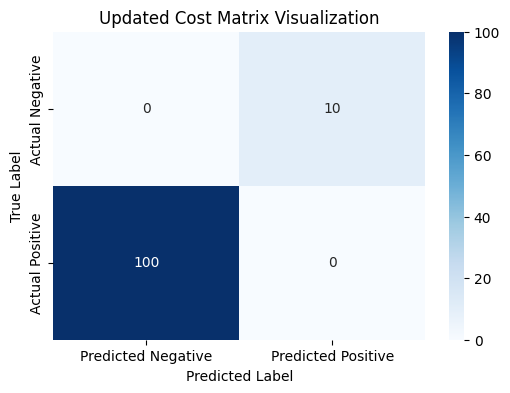

In [101]:
# Visualize the updated cost matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cost_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cost Matrix Visualization')
plt.show()

## Feature importance

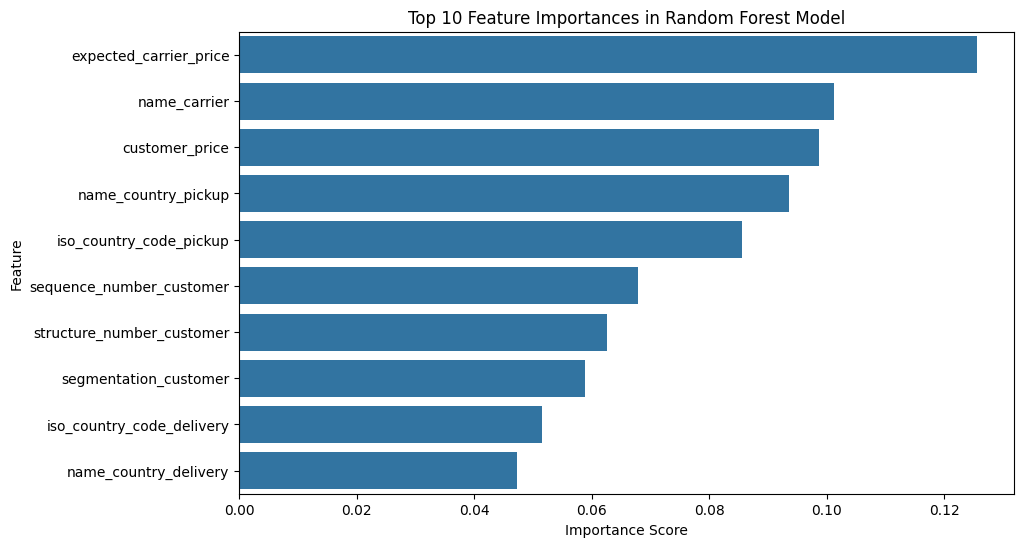

In [92]:
# Feature Importance Analysis
importances = pd.Series(final_rf.feature_importances_, index=X_selected_train.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Business Interpretation

In [93]:
print("\nBusiness Interpretation of Results:")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
for label, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")


Business Interpretation of Results:
Test Set Accuracy: 0.9753
ROC AUC: 0.8987
Classification Report:
Express: Precision=0.97, Recall=0.98, F1-score=0.97
Import: Precision=1.00, Recall=1.00, F1-score=1.00
Special: Precision=0.00, Recall=0.00, F1-score=0.00
Standard: Precision=0.98, Recall=0.97, F1-score=0.98
Third_Country: Precision=1.00, Recall=0.89, F1-score=0.94
macro avg: Precision=0.79, Recall=0.77, F1-score=0.78
weighted avg: Precision=0.98, Recall=0.98, F1-score=0.98
